# Packages

In [54]:
#!pip install POT
#!pip install --upgrade numpy
#!pip install gudhi
#!pip install tensorflow_addons
#!pip install git+https://github.com/master/tensorflow-riemopt.git
#!pip install eagerpy

In [114]:
import time

### Notes

* We fixed the bug in the code with the PD (X was global instead of local)
* Zhaoyang's method breaks when we don't scale/ when we whiten
* Zhaoygang's code works when we normalize
* Normalizing changes the PD slightly for the swiss role with a hole
* Model is getting stuck in a line

Possible next steps:
* try intializing projection
* talk to zhaoyang about the issue with his code we encountered
* dilation invariant
* thorough parameter tuning

Tune:
* Learning Rate (5)
* decay w/ w/o
* 1 scale: normalized
* sigmoid vs. relu
* number of layers (manually)
* intial weight distribution 

# Cyclinder Result

#### Good Output

* Normalizing
* Random Normal initial weights with high learning rate
* Random Uniform initial weights with low learning rate
* sigmoid activiation function better than relu 
* 1-3 hidden layers
* epochs 

#### Bad Output

* Scaling by dimension
* whitening
* 4+ hidden layers 
* Sometimes we observed the projection can get stuck in a line

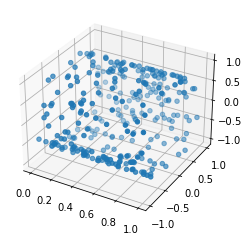

In [115]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

## Import

In [116]:
import numpy               as np
import tensorflow_addons   as tfa
import tensorflow          as tf
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd
import keras.backend as K

from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


#import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

In [117]:
# import packages
import scipy
from scipy.stats import norm 
import time
import statsmodels.api as sm
import math
#from scipy.cluster.vq import whiten
from tensorflow.keras import initializers

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
#from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model

In [119]:
from data_generation import *

## Rips Model

In [120]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()
    

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    
    
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, X, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        self.X = X
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card
        X = self.X

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z=self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

# Data

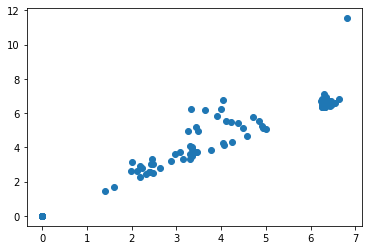

In [16]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = swiss)

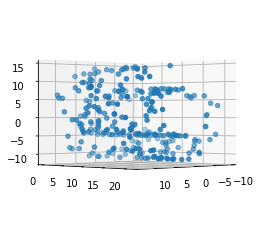

In [17]:
plot(swiss)

In [18]:
X = swiss

## Custom Accuracy

In [121]:
def whiten(X):
    return X/tf.math.reduce_std(X,axis=0)

In [122]:
def normalize(X):
    return (X - tf.math.reduce_mean(X,axis=0))/tf.math.reduce_std(X,axis=0)

In [20]:
class CustomAccuracy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

In [123]:
class CustomAccuracy_norm(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

                
        X = normalize(X) #*(n_samples**(1/X.shape[1]))
        Y = normalize(Y) #*(n_samples**(1/Y.shape[1]))
        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

In [21]:
class CustomAccuracy_normalize(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        X = normalize(X) #*(n_samples**(1/X.shape[1]))
        Y = normalize(Y) #*(n_samples**(1/Y.shape[1]))
        
        st = gd.RipsComplex(points = Y, 
                    max_edge_length = 12).create_simplex_tree(max_dimension=2)
        st.persistence() #computes persistence intervals

        #extract persistence intervals for specified dim
        D1 = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)
        
        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y,X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]

        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)

        Xdgm = modelR.call()[0]
        #D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

In [51]:
class CustomAccuracy_whiten(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        X = whiten(X)
        Y = whiten(Y)
        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()
        
        st = gd.RipsComplex(points = Y, 
                    max_edge_length = 12).create_simplex_tree(max_dimension=2)
        st.persistence() #computes persistence intervals

        #extract persistence intervals for specified dim
        D2 = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)
        
        print("PD using gudhi",D2)

        modelR = RipsModel(P=Y,X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]

        #projected data
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D2[:,0], D2[:,1], c="blue", alpha=0.8)
        
        
        #original data
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()
        
        print("PD using zhaoyang",D)
        




        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

In [60]:
class CustomAccuracy_gudhi(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()
        
        #Project Data
        st = gd.RipsComplex(points = Y, 
                    max_edge_length = 12).create_simplex_tree(max_dimension=2)
        st.persistence() #computes persistence intervals

        #extract persistence intervals for specified dim
        Zdgm = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)
        
        
        #Original Data
        st = gd.RipsComplex(points = X, 
                    max_edge_length = 12).create_simplex_tree(max_dimension=2)
        st.persistence() #computes persistence intervals

        #extract persistence intervals for specified dim
        Xdgm = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)
        

        #modelR = RipsModel(P=Y,X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        #Zdgm = modelR.call()[1]

        #projected data
        D = Zdgm
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        
        
        #original data
        #Xdgm = modelR.call()[0]
        D1 = Xdgm
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()

        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

In [124]:
class CustomAccuracy_tune(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

                
        X = normalize(X) #*(n_samples**(1/X.shape[1]))
        Y = normalize(Y) #*(n_samples**(1/Y.shape[1]))
        

        modelR = RipsModel(P=Y, X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        Xdgm = modelR.call()[0]



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

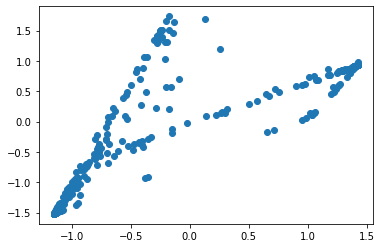

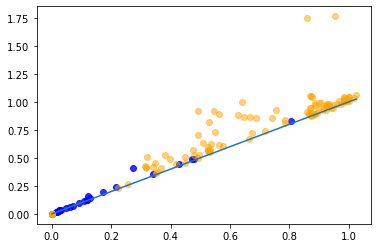

In [143]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
X = swiss

lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr,
                decay_steps=100000,
                decay_rate=0.96,
                staircase=True)
activation = "sigmoid"
layer = 2
initializer = initializers.GlorotNormal(seed=1)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(2)
        ])

                
model.compile(loss=CustomAccuracy_norm(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_decay, name='Adam'),run_eagerly=True)
history = model.fit(X, X,epochs=1,batch_size=n_samples,verbose = 0) 

### Parameter Tuning


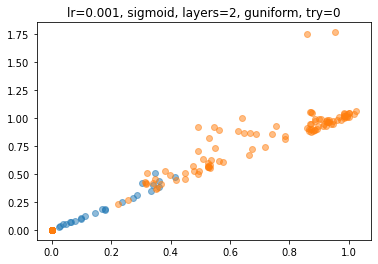

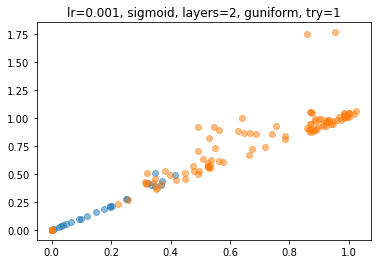

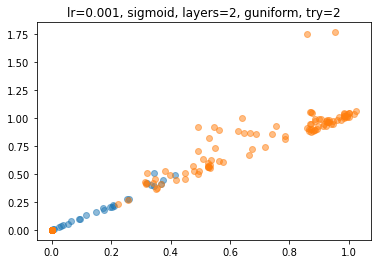

lr=0.001, sigmoid, layers=2, guniform
Final Average Loss:  1.3243005275726318
Iteration Execution Time (min) 11.45355455080668


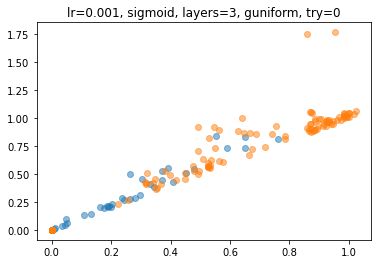

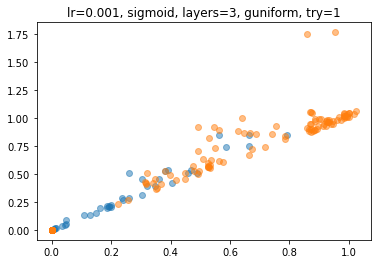

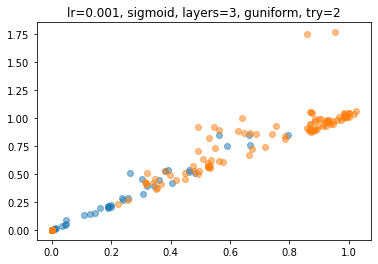

lr=0.001, sigmoid, layers=3, guniform
Final Average Loss:  1.117133657137553
Iteration Execution Time (min) 18.029838760693867


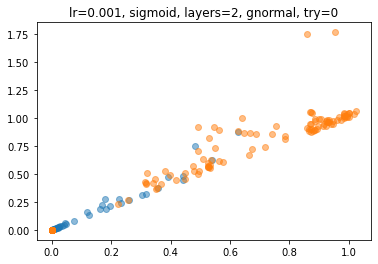

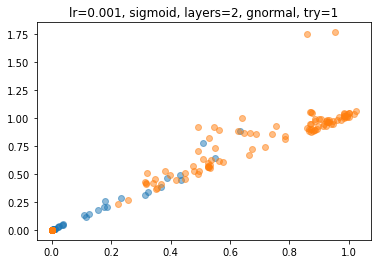

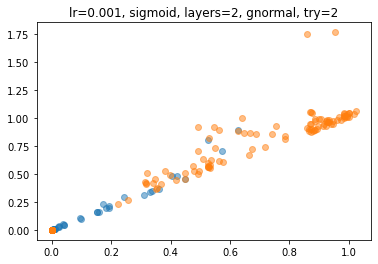

lr=0.001, sigmoid, layers=2, gnormal
Final Average Loss:  1.205458164215088
Iteration Execution Time (min) 14.113370152314504


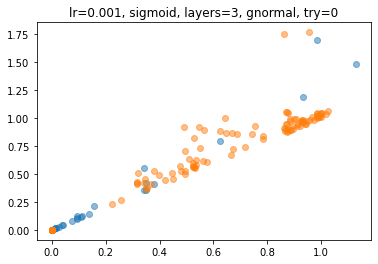

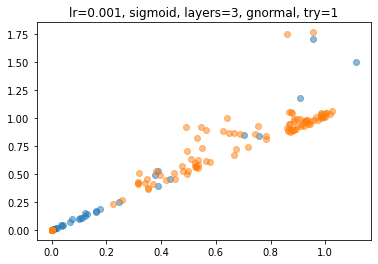

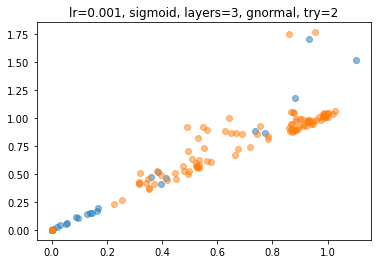

lr=0.001, sigmoid, layers=3, gnormal
Final Average Loss:  0.6706386804580688
Iteration Execution Time (min) 11.546113936106364


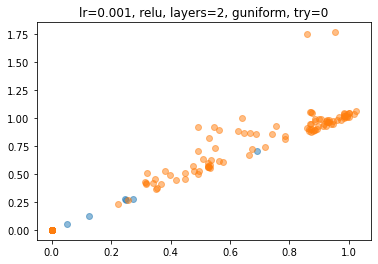

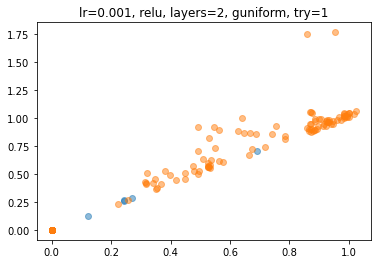

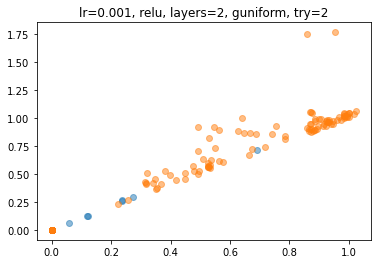

lr=0.001, relu, layers=2, guniform
Final Average Loss:  1.3624333540598552
Iteration Execution Time (min) 11.468107732137044


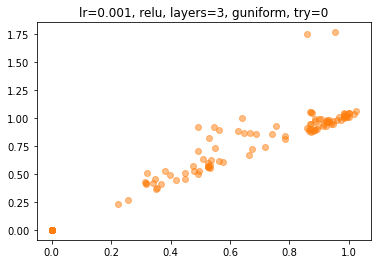

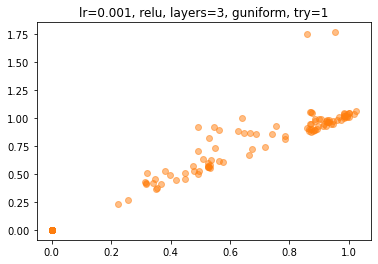

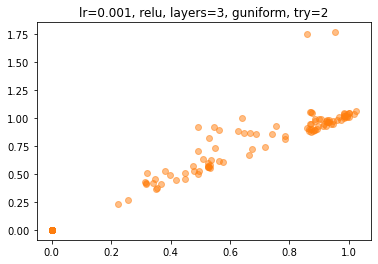

lr=0.001, relu, layers=3, guniform
Final Average Loss:  1.3677355845769246
Iteration Execution Time (min) 11.555608832836151


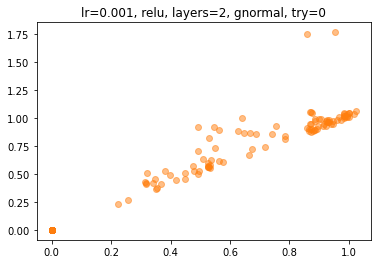

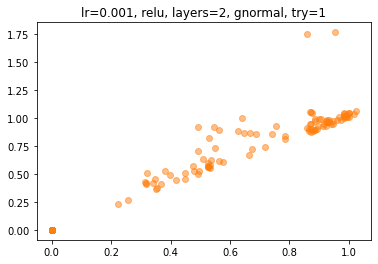

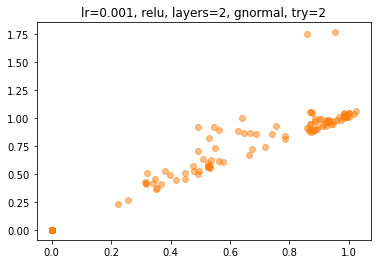

lr=0.001, relu, layers=2, gnormal
Final Average Loss:  1.367736021677653
Iteration Execution Time (min) 11.524220518271129


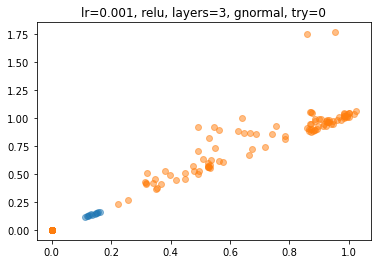

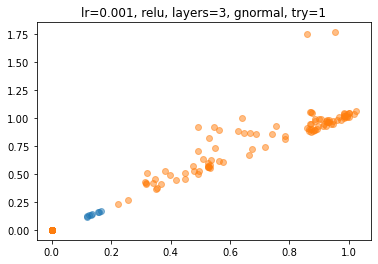

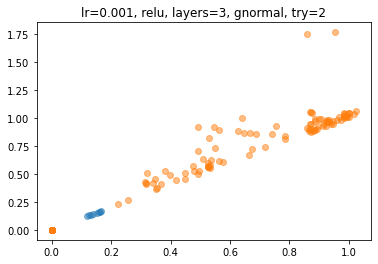

lr=0.001, relu, layers=3, gnormal
Final Average Loss:  1.3677724599838257
Iteration Execution Time (min) 12.056673153241475


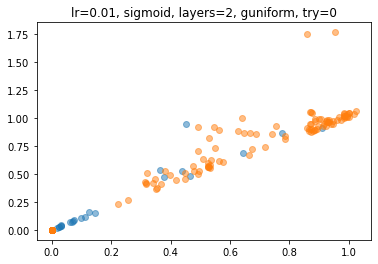

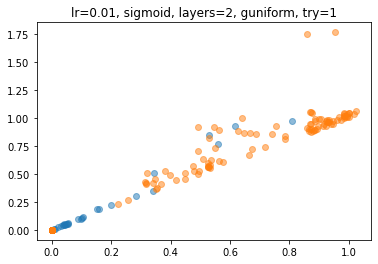

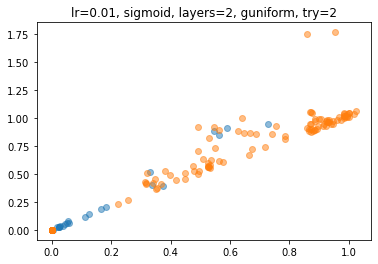

lr=0.01, sigmoid, layers=2, guniform
Final Average Loss:  1.1439414024353027
Iteration Execution Time (min) 11.726510616143544


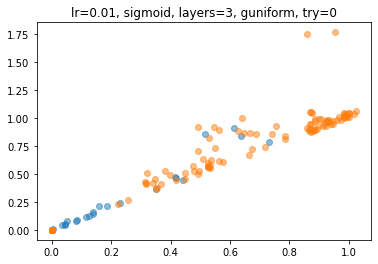

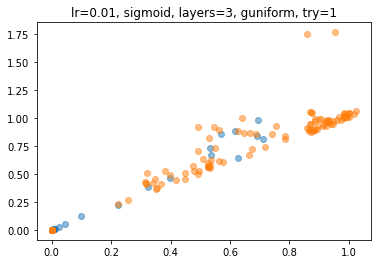

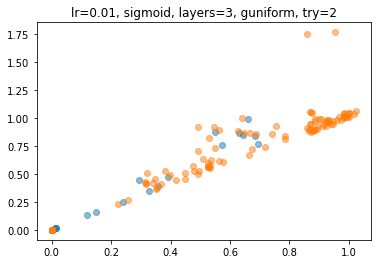

lr=0.01, sigmoid, layers=3, guniform
Final Average Loss:  1.0649537642796834
Iteration Execution Time (min) 11.474116734663646


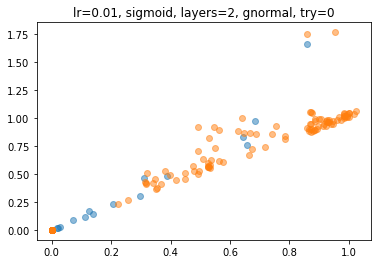

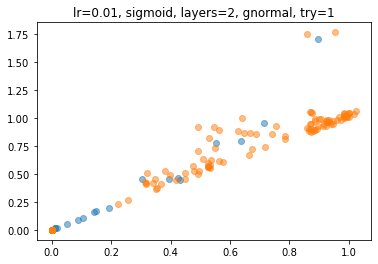

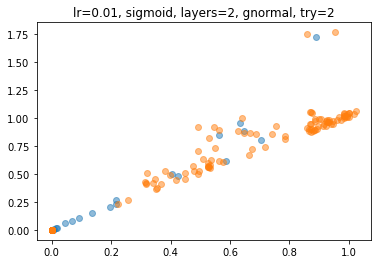

lr=0.01, sigmoid, layers=2, gnormal
Final Average Loss:  0.7749115029970804
Iteration Execution Time (min) 11.616780030727387


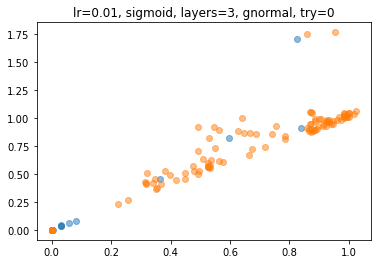

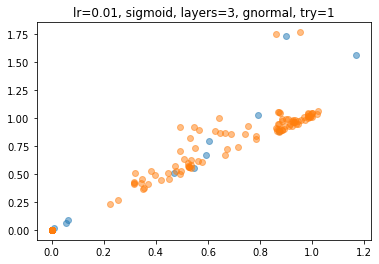

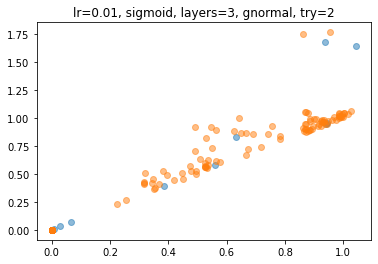

lr=0.01, sigmoid, layers=3, gnormal
Final Average Loss:  0.7069090406099955
Iteration Execution Time (min) 11.50796593427658


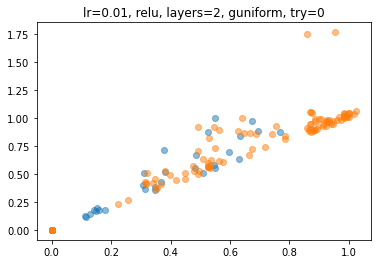

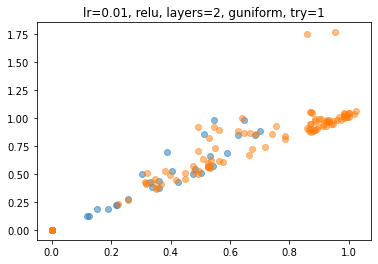

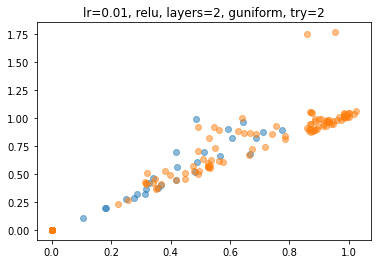

lr=0.01, relu, layers=2, guniform
Final Average Loss:  0.9584566156069437
Iteration Execution Time (min) 11.630465066432953


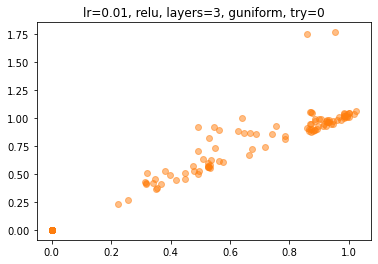

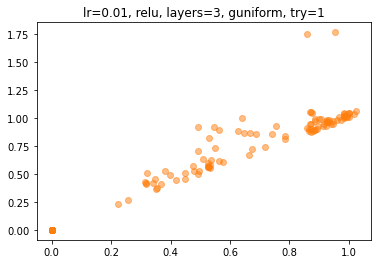

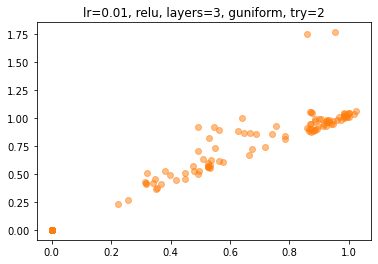

lr=0.01, relu, layers=3, guniform
Final Average Loss:  1.367735783259074
Iteration Execution Time (min) 11.295937232176463


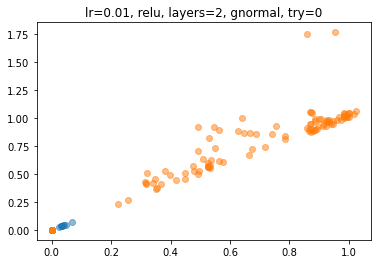

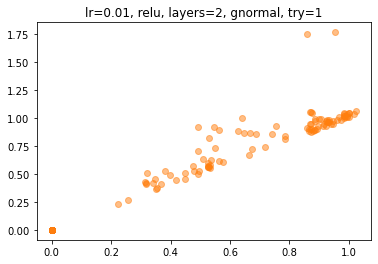

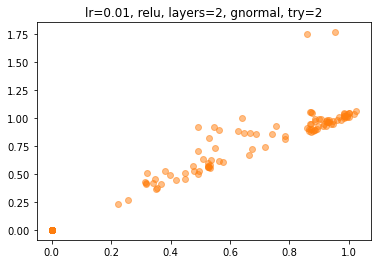

lr=0.01, relu, layers=2, gnormal
Final Average Loss:  1.3677553335825603
Iteration Execution Time (min) 11.792662747701009


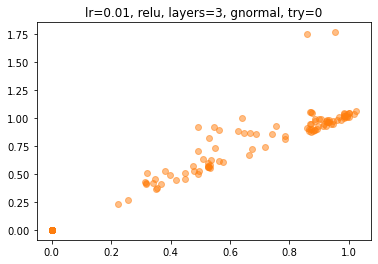

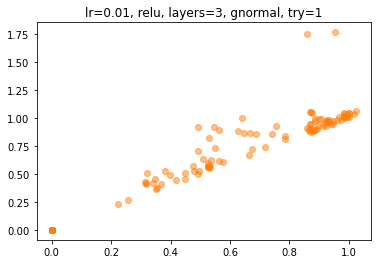

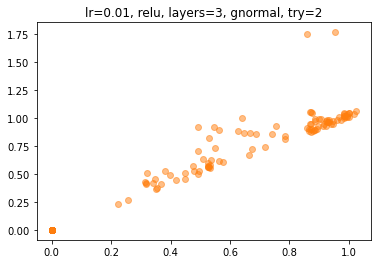

lr=0.01, relu, layers=3, gnormal
Final Average Loss:  1.367735465367635
Iteration Execution Time (min) 11.788900168736776


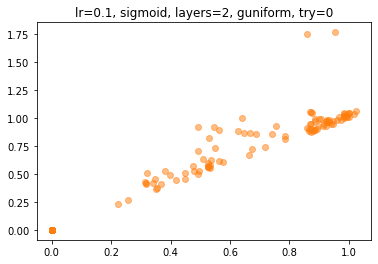

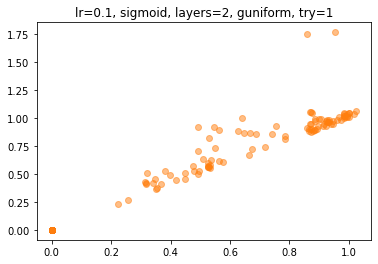

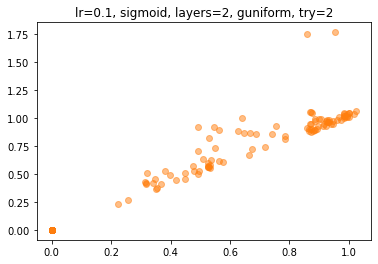

lr=0.1, sigmoid, layers=2, guniform
Final Average Loss:  1.367742896080017
Iteration Execution Time (min) 11.649203630288442


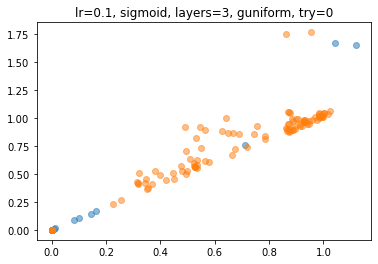

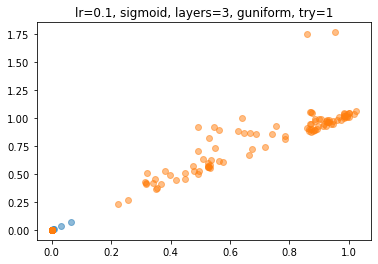

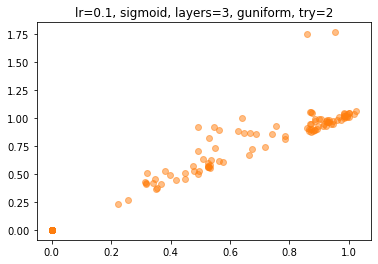

lr=0.1, sigmoid, layers=3, guniform
Final Average Loss:  1.1620392600695293
Iteration Execution Time (min) 11.729725698630014


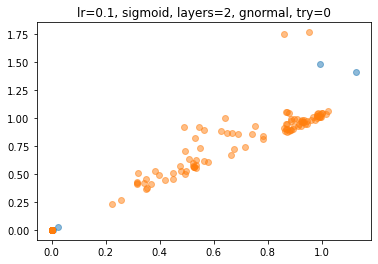

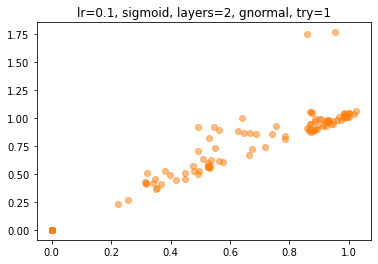

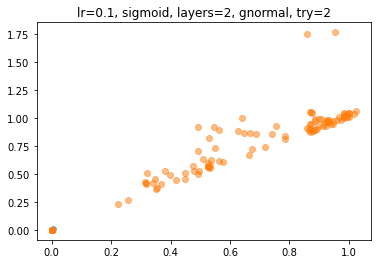

lr=0.1, sigmoid, layers=2, gnormal
Final Average Loss:  1.2539972464243572
Iteration Execution Time (min) 11.730352516969045


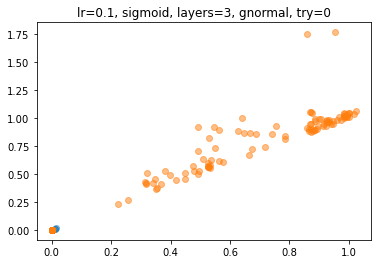

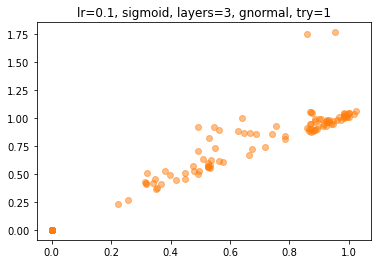

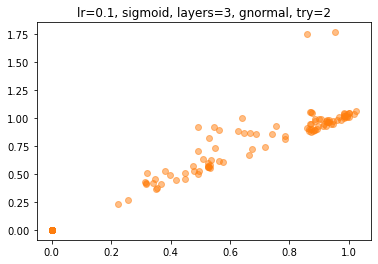

lr=0.1, sigmoid, layers=3, gnormal
Final Average Loss:  1.3677359024683635
Iteration Execution Time (min) 11.699946117401122


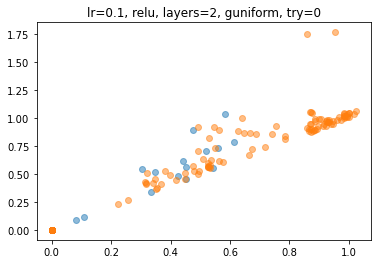

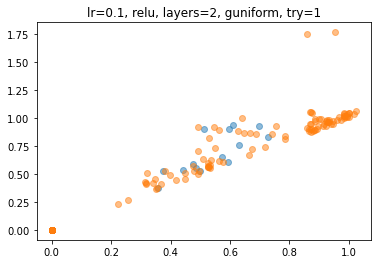

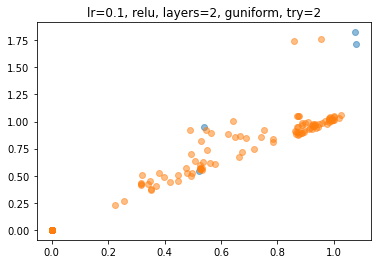

lr=0.1, relu, layers=2, guniform
Final Average Loss:  0.9062063694000244
Iteration Execution Time (min) 12.065546099344889


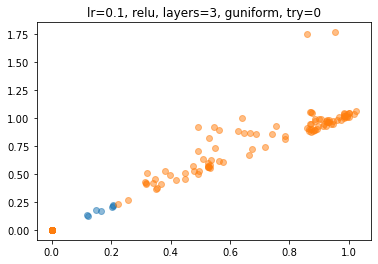

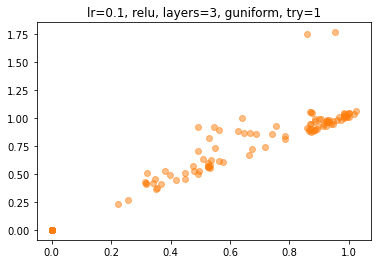

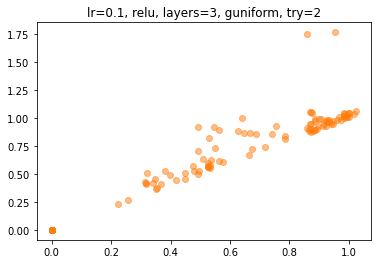

lr=0.1, relu, layers=3, guniform
Final Average Loss:  1.3680626551310222
Iteration Execution Time (min) 12.20232661565145


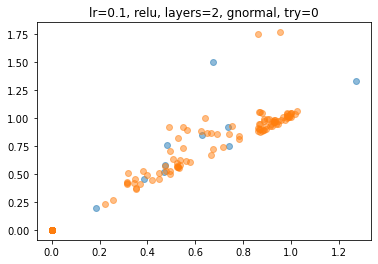

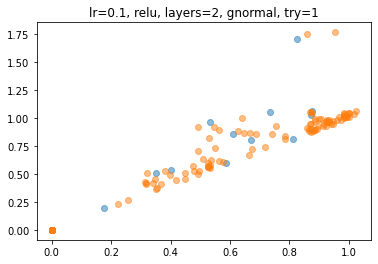

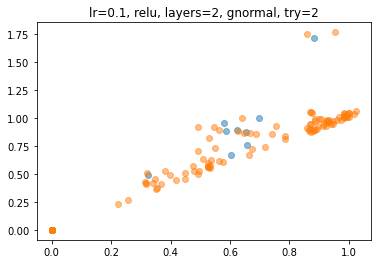

lr=0.1, relu, layers=2, gnormal
Final Average Loss:  0.7253121733665466
Iteration Execution Time (min) 11.784414112567902


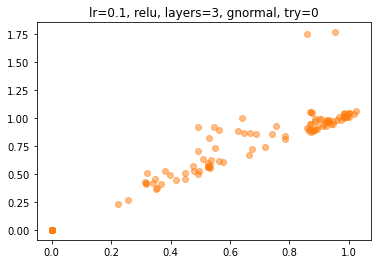

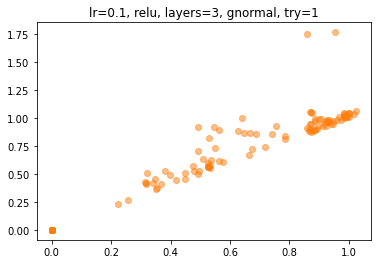

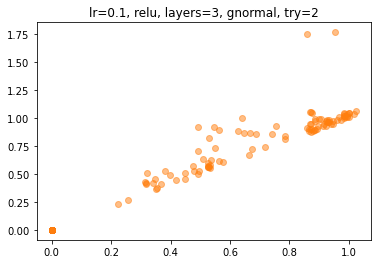

lr=0.1, relu, layers=3, gnormal
Final Average Loss:  1.3677362203598022
Iteration Execution Time (min) 11.588795534769694


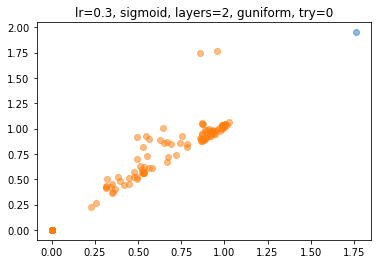

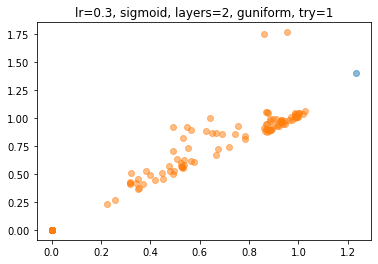

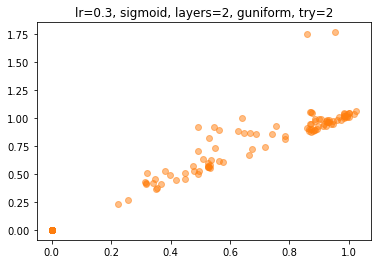

lr=0.3, sigmoid, layers=2, guniform
Final Average Loss:  1.3667032321294148
Iteration Execution Time (min) 11.472629181543986


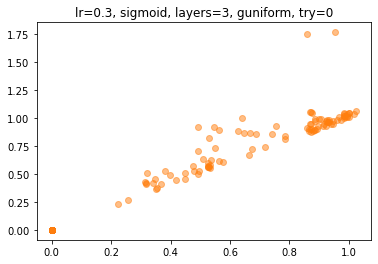

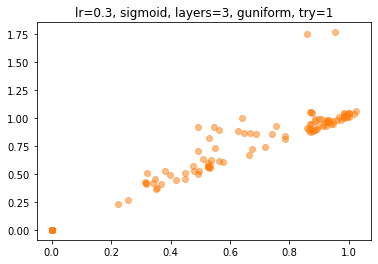

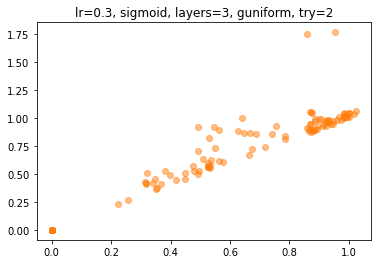

lr=0.3, sigmoid, layers=3, guniform
Final Average Loss:  1.3677357037862141
Iteration Execution Time (min) 11.551525151729583


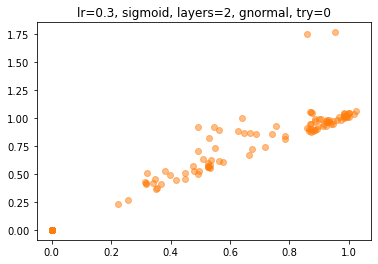

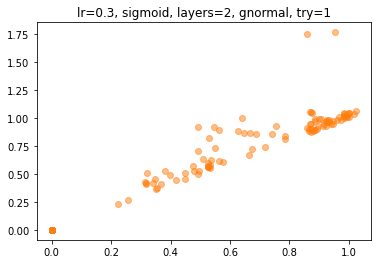

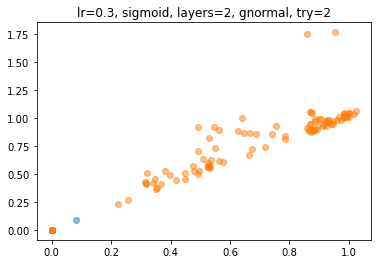

lr=0.3, sigmoid, layers=2, gnormal
Final Average Loss:  1.3677357037862141
Iteration Execution Time (min) 11.42083681821823


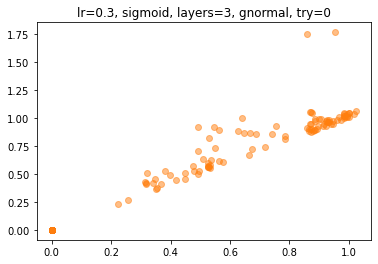

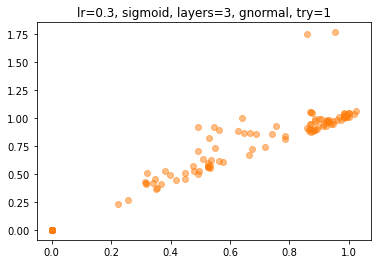

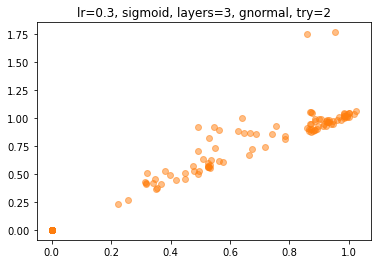

lr=0.3, sigmoid, layers=3, gnormal
Final Average Loss:  1.3677361408869426
Iteration Execution Time (min) 11.450480099519094


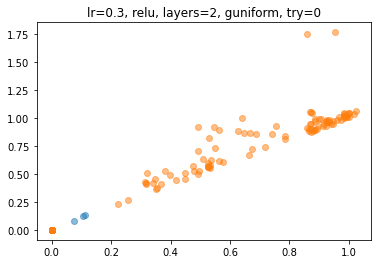

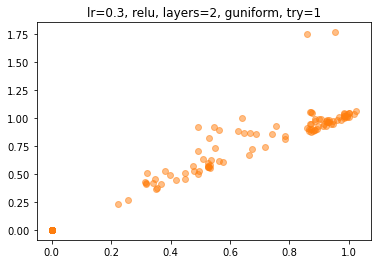

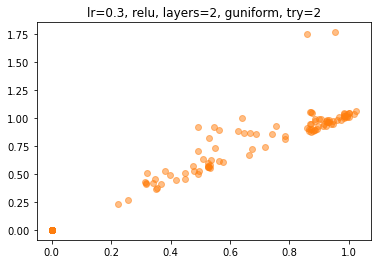

lr=0.3, relu, layers=2, guniform
Final Average Loss:  1.3678518533706665
Iteration Execution Time (min) 12.174224400520325


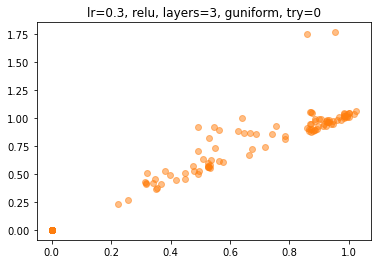

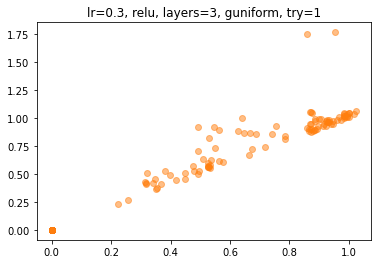

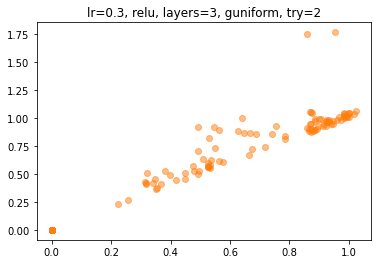

lr=0.3, relu, layers=3, guniform
Final Average Loss:  1.3677360614140828
Iteration Execution Time (min) 11.472048699855804


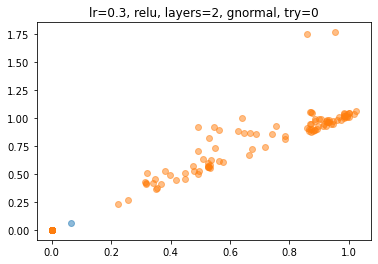

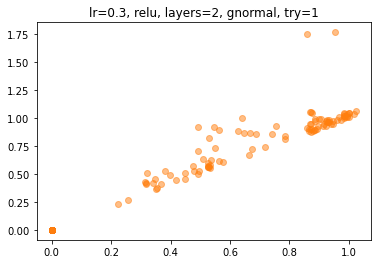

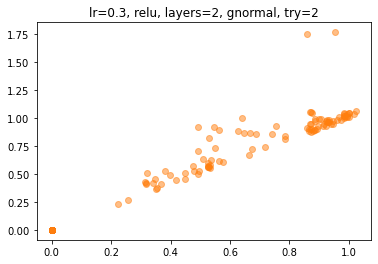

lr=0.3, relu, layers=2, gnormal
Final Average Loss:  1.3677364985148113
Iteration Execution Time (min) 11.901153600215912


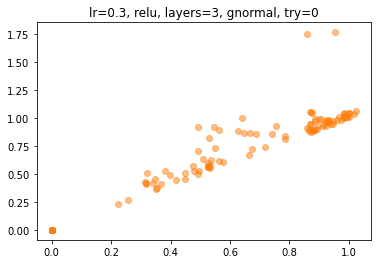

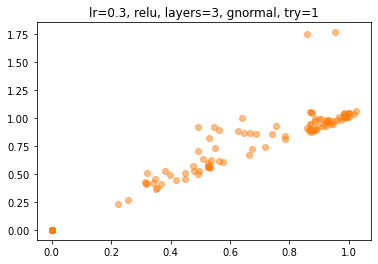

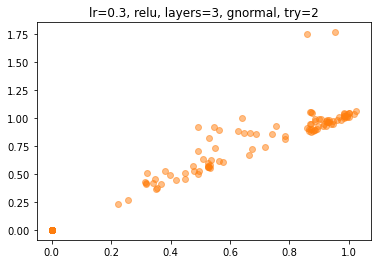

lr=0.3, relu, layers=3, gnormal
Final Average Loss:  1.367735743522644
Iteration Execution Time (min) 12.017089319229125
The best parameters:  lr=0.01, sigmoid, layers=3, gnormal, try=2
The smallest loss:  0.6129381656646729
Execution Time (hrs):  6.374852431085374


{'lr=0.001, sigmoid, layers=2, guniform, try=0': 1.32782781124115,
 'lr=0.001, sigmoid, layers=2, guniform, try=1': 1.3227719068527222,
 'lr=0.001, sigmoid, layers=2, guniform, try=2': 1.3223018646240234,
 'lr=0.001, sigmoid, layers=3, guniform, try=0': 1.1220530271530151,
 'lr=0.001, sigmoid, layers=3, guniform, try=1': 1.1151392459869385,
 'lr=0.001, sigmoid, layers=3, guniform, try=2': 1.114208698272705,
 'lr=0.001, sigmoid, layers=2, gnormal, try=0': 1.222037672996521,
 'lr=0.001, sigmoid, layers=2, gnormal, try=1': 1.2067593336105347,
 'lr=0.001, sigmoid, layers=2, gnormal, try=2': 1.187577486038208,
 'lr=0.001, sigmoid, layers=3, gnormal, try=0': 0.6994068026542664,
 'lr=0.001, sigmoid, layers=3, gnormal, try=1': 0.6655131578445435,
 'lr=0.001, sigmoid, layers=3, gnormal, try=2': 0.6469960808753967,
 'lr=0.001, relu, layers=2, guniform, try=0': 1.364391565322876,
 'lr=0.001, relu, layers=2, guniform, try=1': 1.3624290227890015,
 'lr=0.001, relu, layers=2, guniform, try=2': 1.3604

In [145]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
X = swiss

lrs = [0.001,0.01,0.1,0.3]
activations = ["sigmoid","relu"]
layers_list = [2,3]
weights = ["guniform","gnormal"]

n_samples = 300
best_loss_id = ""
best_loss = np.inf
repeat = 3


dictionary={}

start = time.time()
for lr in lrs:
    for activation in activations:
        for weight in weights:
            for layer in layers_list:
                
                loop_start = time.time()
                

                lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                                initial_learning_rate=lr,
                                decay_steps=100000,
                                decay_rate=0.96,
                                staircase=True)
            
                if weight== "gnormal": 
                    initializer = initializers.GlorotNormal(seed=1)
                else:
                    initializer = initializers.GlorotUniform(seed=1)

                if layer == 2:
                    model = tf.keras.models.Sequential([
                            tf.keras.layers.Flatten(input_shape=(3, )),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(2)
                            ])
                else: 
                    model = tf.keras.models.Sequential([
                            tf.keras.layers.Flatten(input_shape=(3, )),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
                            tf.keras.layers.Dense(2)
                            ])

                avg_loss = 0

                for i in range(repeat):
                    
                    combo = "lr={}, {}, layers={}, {}, try={}".format(lr,activation,layer,weight,i)
                
                    model.compile(loss=CustomAccuracy_tune(),optimizer = tf.keras.optimizers.Adam(
                        learning_rate=lr_decay, name='Adam'),run_eagerly=True)
                    history = model.fit(X, X,epochs=50,batch_size=n_samples,verbose=0) 
                    final_loss = history.history["loss"][-1]

                    dictionary[combo] = final_loss
                    
                    if final_loss < best_loss:
                        best_loss_id = combo
                        best_loss = final_loss
                        
                    avg_loss += final_loss
                    

                    PD(normalize(model.predict(X)))
                    PD(normalize(X))
                    plt.title(combo)
                    plt.show() 
                    
                    
            
                avg_loss = avg_loss/repeat
                print("lr={}, {}, layers={}, {}".format(lr,activation,layer,weight))
                print("Final Average Loss: ", avg_loss)
                
                loop_end = time.time()
                print("Iteration Execution Time (min)",(loop_end-loop_start)/60)

end = time.time()
print("The best parameters: ", best_loss_id)
print("The smallest loss: ", best_loss)
print("Execution Time (hrs): ", (end-start)/3600)

display(dictionary)


In [147]:
tuning_output = {'lr=0.001, sigmoid, layers=2, guniform, try=0': 1.32782781124115,
 'lr=0.001, sigmoid, layers=2, guniform, try=1': 1.3227719068527222,
 'lr=0.001, sigmoid, layers=2, guniform, try=2': 1.3223018646240234,
 'lr=0.001, sigmoid, layers=3, guniform, try=0': 1.1220530271530151,
 'lr=0.001, sigmoid, layers=3, guniform, try=1': 1.1151392459869385,
 'lr=0.001, sigmoid, layers=3, guniform, try=2': 1.114208698272705,
 'lr=0.001, sigmoid, layers=2, gnormal, try=0': 1.222037672996521,
 'lr=0.001, sigmoid, layers=2, gnormal, try=1': 1.2067593336105347,
 'lr=0.001, sigmoid, layers=2, gnormal, try=2': 1.187577486038208,
 'lr=0.001, sigmoid, layers=3, gnormal, try=0': 0.6994068026542664,
 'lr=0.001, sigmoid, layers=3, gnormal, try=1': 0.6655131578445435,
 'lr=0.001, sigmoid, layers=3, gnormal, try=2': 0.6469960808753967,
 'lr=0.001, relu, layers=2, guniform, try=0': 1.364391565322876,
 'lr=0.001, relu, layers=2, guniform, try=1': 1.3624290227890015,
 'lr=0.001, relu, layers=2, guniform, try=2': 1.360479474067688,
 'lr=0.001, relu, layers=3, guniform, try=0': 1.367735505104065,
 'lr=0.001, relu, layers=3, guniform, try=1': 1.3677358627319336,
 'lr=0.001, relu, layers=3, guniform, try=2': 1.3677353858947754,
 'lr=0.001, relu, layers=2, gnormal, try=0': 1.3677366971969604,
 'lr=0.001, relu, layers=2, gnormal, try=1': 1.367735505104065,
 'lr=0.001, relu, layers=2, gnormal, try=2': 1.3677358627319336,
 'lr=0.001, relu, layers=3, gnormal, try=0': 1.367782711982727,
 'lr=0.001, relu, layers=3, gnormal, try=1': 1.367762565612793,
 'lr=0.001, relu, layers=3, gnormal, try=2': 1.367772102355957,
 'lr=0.01, sigmoid, layers=2, guniform, try=0': 1.2191674709320068,
 'lr=0.01, sigmoid, layers=2, guniform, try=1': 1.1277217864990234,
 'lr=0.01, sigmoid, layers=2, guniform, try=2': 1.084934949874878,
 'lr=0.01, sigmoid, layers=3, guniform, try=0': 1.144849181175232,
 'lr=0.01, sigmoid, layers=3, guniform, try=1': 1.0360397100448608,
 'lr=0.01, sigmoid, layers=3, guniform, try=2': 1.0139724016189575,
 'lr=0.01, sigmoid, layers=2, gnormal, try=0': 0.808953046798706,
 'lr=0.01, sigmoid, layers=2, gnormal, try=1': 0.7846953272819519,
 'lr=0.01, sigmoid, layers=2, gnormal, try=2': 0.7310861349105835,
 'lr=0.01, sigmoid, layers=3, gnormal, try=0': 0.8928375840187073,
 'lr=0.01, sigmoid, layers=3, gnormal, try=1': 0.6149513721466064,
 'lr=0.01, sigmoid, layers=3, gnormal, try=2': 0.6129381656646729,
 'lr=0.01, relu, layers=2, guniform, try=0': 0.9675828814506531,
 'lr=0.01, relu, layers=2, guniform, try=1': 0.9612482190132141,
 'lr=0.01, relu, layers=2, guniform, try=2': 0.9465387463569641,
 'lr=0.01, relu, layers=3, guniform, try=0': 1.3677364587783813,
 'lr=0.01, relu, layers=3, guniform, try=1': 1.3677353858947754,
 'lr=0.01, relu, layers=3, guniform, try=2': 1.367735505104065,
 'lr=0.01, relu, layers=2, gnormal, try=0': 1.3677946329116821,
 'lr=0.01, relu, layers=2, gnormal, try=1': 1.367735505104065,
 'lr=0.01, relu, layers=2, gnormal, try=2': 1.3677358627319336,
 'lr=0.01, relu, layers=3, gnormal, try=0': 1.367735505104065,
 'lr=0.01, relu, layers=3, gnormal, try=1': 1.367735505104065,
 'lr=0.01, relu, layers=3, gnormal, try=2': 1.3677353858947754,
 'lr=0.1, sigmoid, layers=2, guniform, try=0': 1.3677364587783813,
 'lr=0.1, sigmoid, layers=2, guniform, try=1': 1.3677361011505127,
 'lr=0.1, sigmoid, layers=2, guniform, try=2': 1.3677561283111572,
 'lr=0.1, sigmoid, layers=3, guniform, try=0': 0.7506301999092102,
 'lr=0.1, sigmoid, layers=3, guniform, try=1': 1.3677514791488647,
 'lr=0.1, sigmoid, layers=3, guniform, try=2': 1.3677361011505127,
 'lr=0.1, sigmoid, layers=2, gnormal, try=0': 1.026519775390625,
 'lr=0.1, sigmoid, layers=2, gnormal, try=1': 1.3677358627319336,
 'lr=0.1, sigmoid, layers=2, gnormal, try=2': 1.3677361011505127,
 'lr=0.1, sigmoid, layers=3, gnormal, try=0': 1.3677366971969604,
 'lr=0.1, sigmoid, layers=3, gnormal, try=1': 1.367735505104065,
 'lr=0.1, sigmoid, layers=3, gnormal, try=2': 1.367735505104065,
 'lr=0.1, relu, layers=2, guniform, try=0': 1.0781177282333374,
 'lr=0.1, relu, layers=2, guniform, try=1': 0.9981573820114136,
 'lr=0.1, relu, layers=2, guniform, try=2': 0.6423439979553223,
 'lr=0.1, relu, layers=3, guniform, try=0': 1.3687169551849365,
 'lr=0.1, relu, layers=3, guniform, try=1': 1.367735505104065,
 'lr=0.1, relu, layers=3, guniform, try=2': 1.367735505104065,
 'lr=0.1, relu, layers=2, gnormal, try=0': 0.8458177447319031,
 'lr=0.1, relu, layers=2, gnormal, try=1': 0.6945205926895142,
 'lr=0.1, relu, layers=2, gnormal, try=2': 0.6355981826782227,
 'lr=0.1, relu, layers=3, gnormal, try=0': 1.3677358627319336,
 'lr=0.1, relu, layers=3, gnormal, try=1': 1.3677366971969604,
 'lr=0.1, relu, layers=3, gnormal, try=2': 1.3677361011505127,
 'lr=0.3, sigmoid, layers=2, guniform, try=0': 1.3949370384216309,
 'lr=0.3, sigmoid, layers=2, guniform, try=1': 1.3374371528625488,
 'lr=0.3, sigmoid, layers=2, guniform, try=2': 1.367735505104065,
 'lr=0.3, sigmoid, layers=3, guniform, try=0': 1.367735505104065,
 'lr=0.3, sigmoid, layers=3, guniform, try=1': 1.3677361011505127,
 'lr=0.3, sigmoid, layers=3, guniform, try=2': 1.367735505104065,
 'lr=0.3, sigmoid, layers=2, gnormal, try=0': 1.3677361011505127,
 'lr=0.3, sigmoid, layers=2, gnormal, try=1': 1.367735505104065,
 'lr=0.3, sigmoid, layers=2, gnormal, try=2': 1.367735505104065,
 'lr=0.3, sigmoid, layers=3, gnormal, try=0': 1.3677361011505127,
 'lr=0.3, sigmoid, layers=3, gnormal, try=1': 1.3677364587783813,
 'lr=0.3, sigmoid, layers=3, gnormal, try=2': 1.3677358627319336,
 'lr=0.3, relu, layers=2, guniform, try=0': 1.368084192276001,
 'lr=0.3, relu, layers=2, guniform, try=1': 1.3677358627319336,
 'lr=0.3, relu, layers=2, guniform, try=2': 1.367735505104065,
 'lr=0.3, relu, layers=3, guniform, try=0': 1.3677366971969604,
 'lr=0.3, relu, layers=3, guniform, try=1': 1.3677361011505127,
 'lr=0.3, relu, layers=3, guniform, try=2': 1.3677353858947754,
 'lr=0.3, relu, layers=2, gnormal, try=0': 1.3677380084991455,
 'lr=0.3, relu, layers=2, gnormal, try=1': 1.3677353858947754,
 'lr=0.3, relu, layers=2, gnormal, try=2': 1.3677361011505127,
 'lr=0.3, relu, layers=3, gnormal, try=0': 1.3677358627319336,
 'lr=0.3, relu, layers=3, gnormal, try=1': 1.367735505104065,
 'lr=0.3, relu, layers=3, gnormal, try=2': 1.3677358627319336}

### MODEL GETS STUCK in a line

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

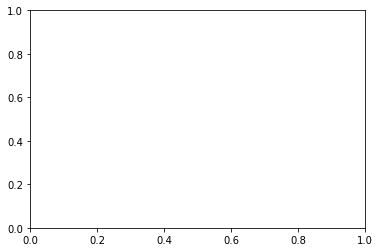

In [100]:
n_samples = 300
initial_learning_rate = 0.01
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.99,
#     staircase=True)

lr_schedule = 5
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu',kernel_initializer="ones"),
        tf.keras.layers.Dense(3, activation='relu',kernel_initializer="ones"),
        tf.keras.layers.Dense(2)
        ])

model.compile(loss=CustomAccuracy_norm(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

### RELU

Epoch 1/30


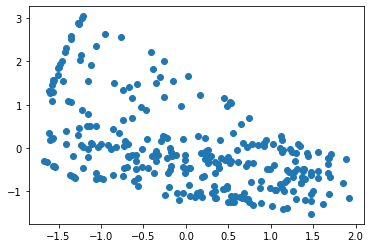

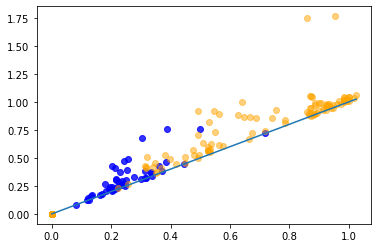

1/1 [==============================] - 5s 5s/step - loss: 1.3154
Epoch 2/30


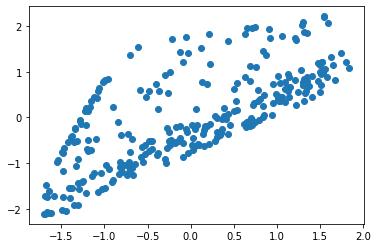

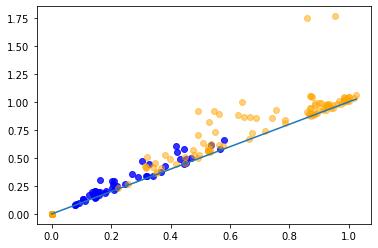

1/1 [==============================] - 5s 5s/step - loss: 1.3257
Epoch 3/30


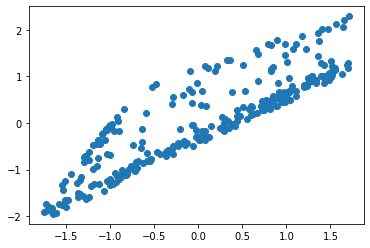

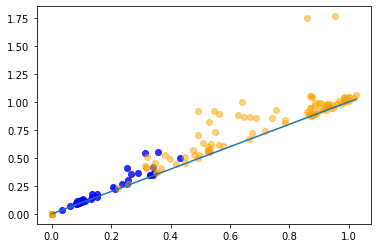

1/1 [==============================] - 5s 5s/step - loss: 1.3381
Epoch 4/30


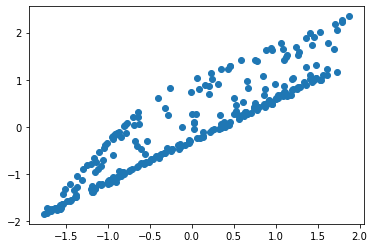

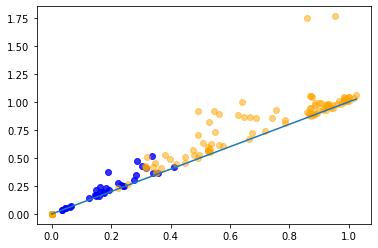

1/1 [==============================] - 5s 5s/step - loss: 1.3566
Epoch 5/30


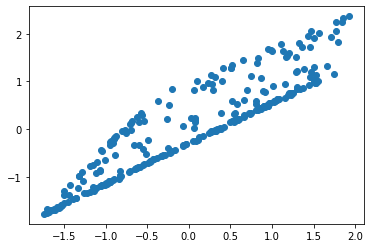

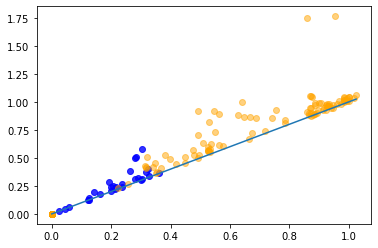

1/1 [==============================] - 5s 5s/step - loss: 1.3507
Epoch 6/30


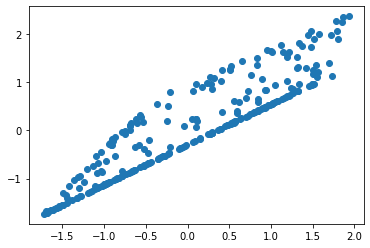

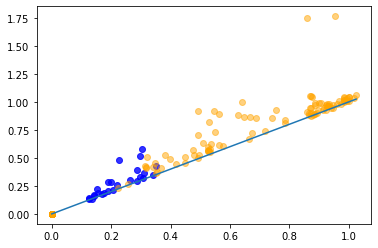

1/1 [==============================] - 5s 5s/step - loss: 1.3571
Epoch 7/30


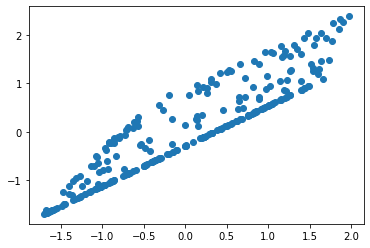

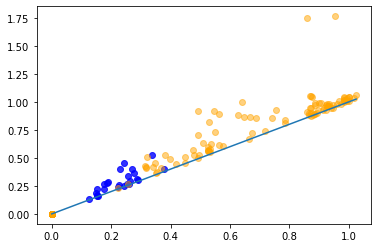

1/1 [==============================] - 5s 5s/step - loss: 1.3679
Epoch 8/30


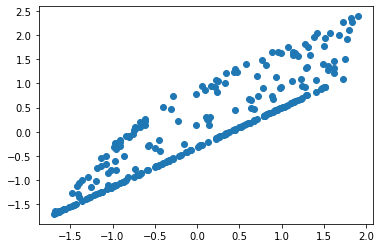

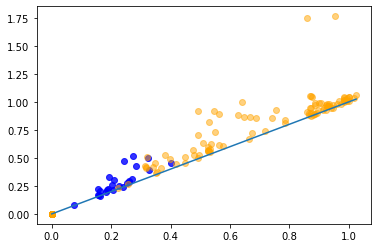

1/1 [==============================] - 5s 5s/step - loss: 1.3560
Epoch 9/30


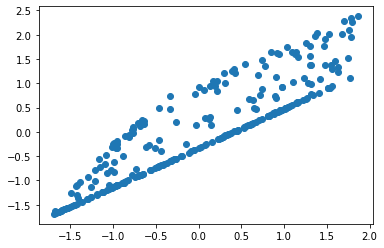

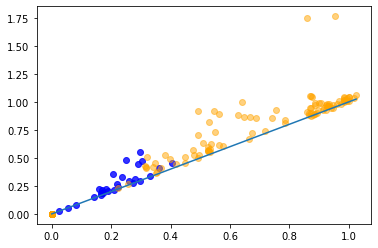

1/1 [==============================] - 5s 5s/step - loss: 1.3600
Epoch 10/30


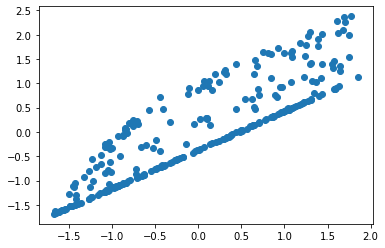

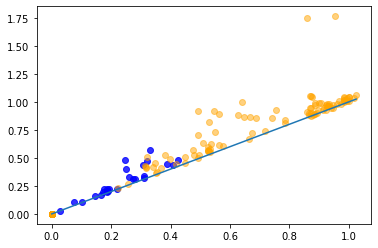

1/1 [==============================] - 5s 5s/step - loss: 1.3411
Epoch 11/30


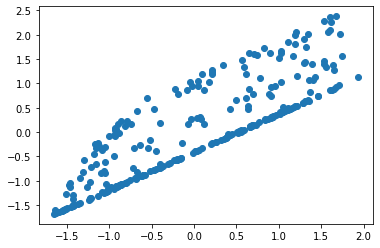

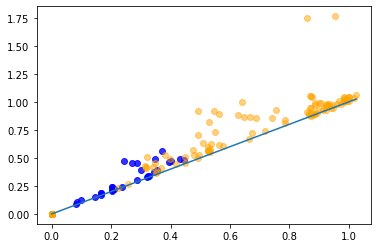

1/1 [==============================] - 5s 5s/step - loss: 1.3298
Epoch 12/30


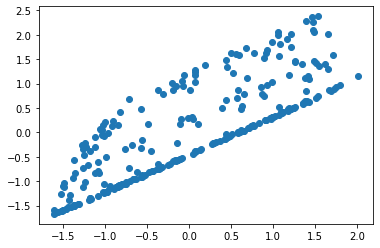

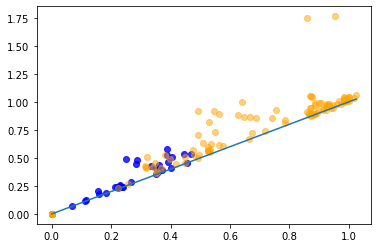

1/1 [==============================] - 5s 5s/step - loss: 1.3245
Epoch 13/30


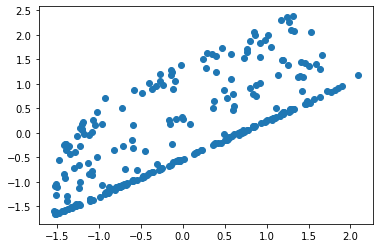

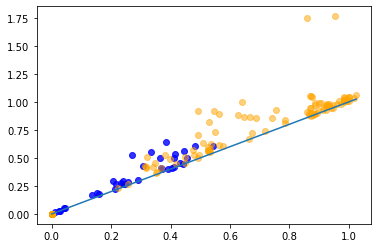

1/1 [==============================] - 5s 5s/step - loss: 1.3130
Epoch 14/30


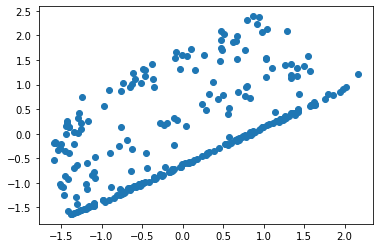

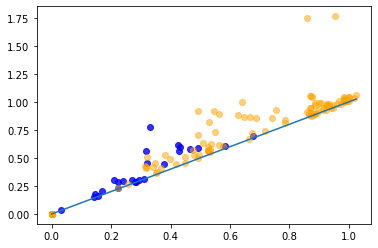

1/1 [==============================] - 5s 5s/step - loss: 1.2764
Epoch 15/30


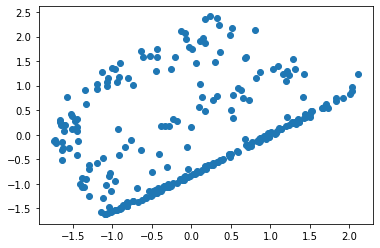

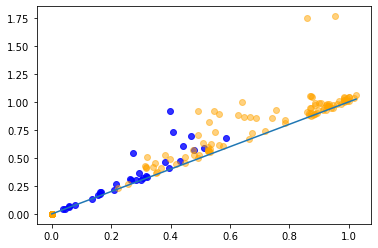

1/1 [==============================] - 5s 5s/step - loss: 1.1938
Epoch 16/30


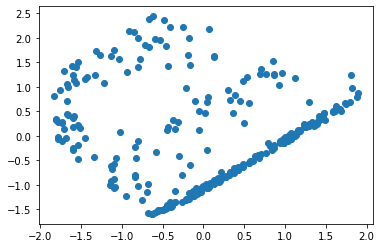

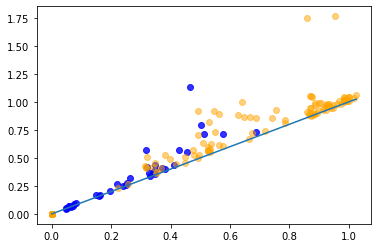

1/1 [==============================] - 5s 5s/step - loss: 1.1656
Epoch 17/30


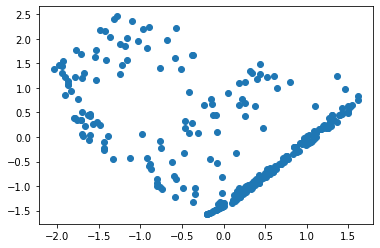

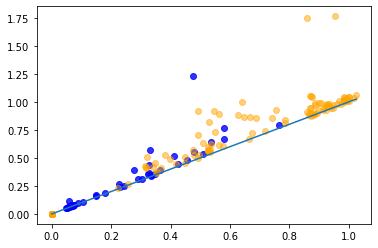

1/1 [==============================] - 5s 5s/step - loss: 1.2423
Epoch 18/30


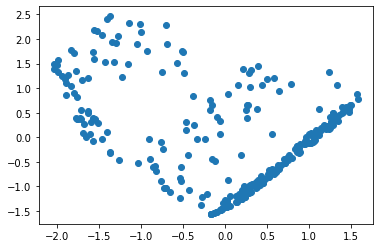

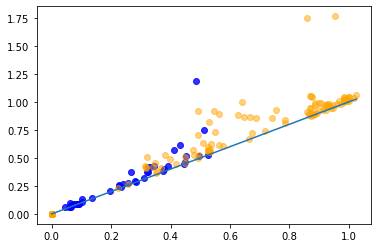

1/1 [==============================] - 5s 5s/step - loss: 1.2498
Epoch 19/30


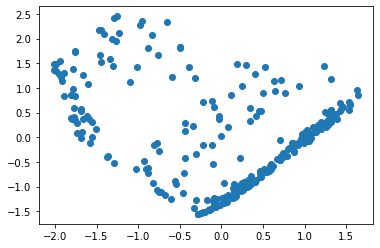

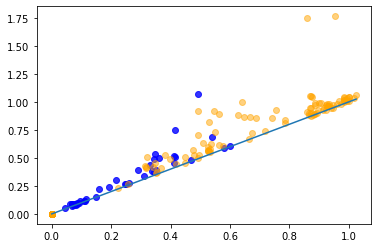

1/1 [==============================] - 5s 5s/step - loss: 1.1994
Epoch 20/30


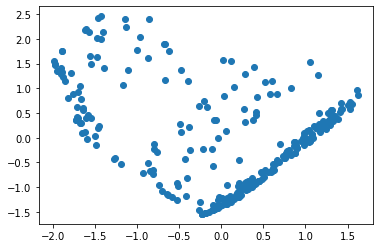

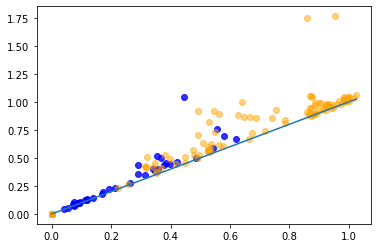

1/1 [==============================] - 5s 5s/step - loss: 1.1692
Epoch 21/30


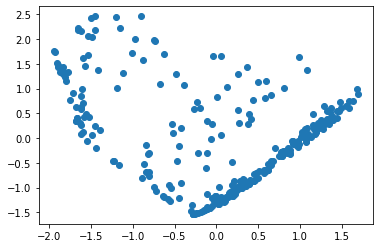

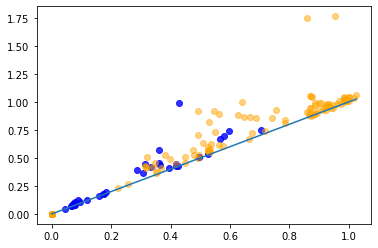

1/1 [==============================] - 5s 5s/step - loss: 1.1541
Epoch 22/30


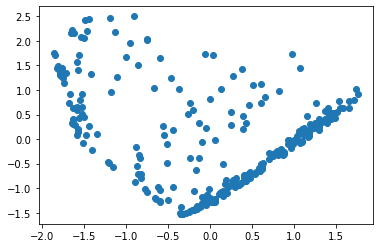

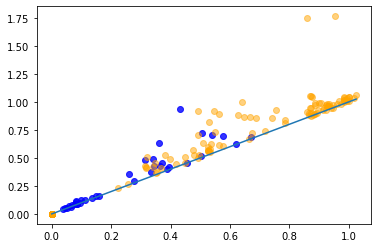

1/1 [==============================] - 5s 5s/step - loss: 1.1693
Epoch 23/30


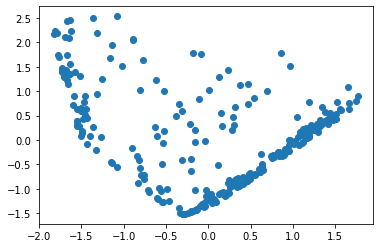

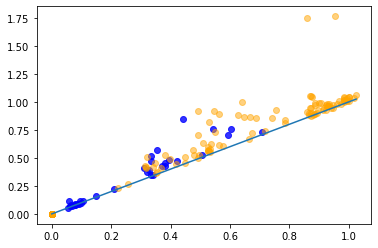

1/1 [==============================] - 5s 5s/step - loss: 1.1318
Epoch 24/30


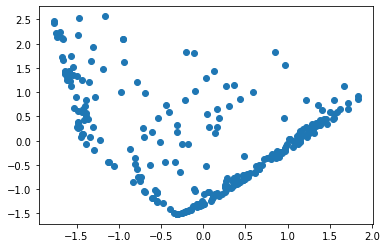

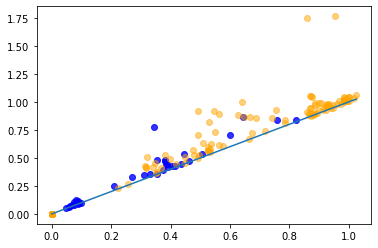

1/1 [==============================] - 5s 5s/step - loss: 1.1750
Epoch 25/30


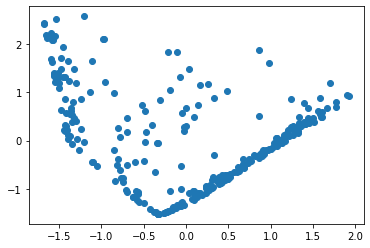

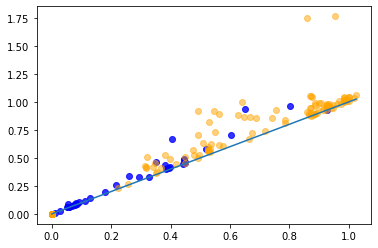

1/1 [==============================] - 6s 6s/step - loss: 1.1968
Epoch 26/30


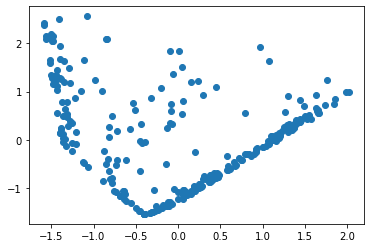

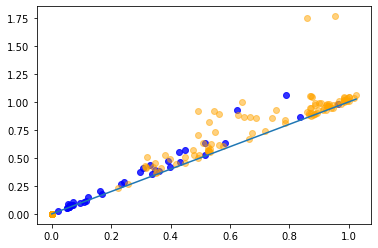

1/1 [==============================] - 5s 5s/step - loss: 1.1850
Epoch 27/30


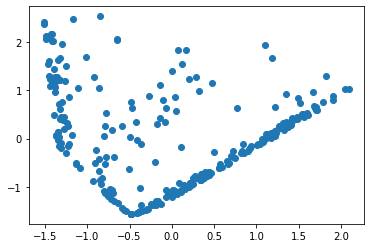

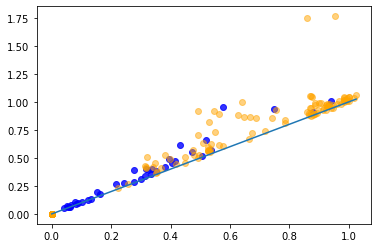

1/1 [==============================] - 5s 5s/step - loss: 1.1520
Epoch 28/30


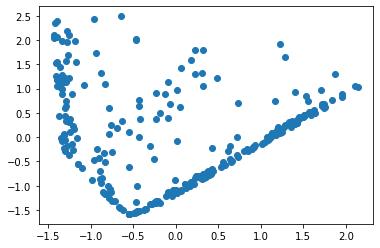

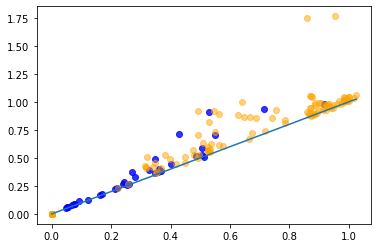

1/1 [==============================] - 5s 5s/step - loss: 1.1209
Epoch 29/30


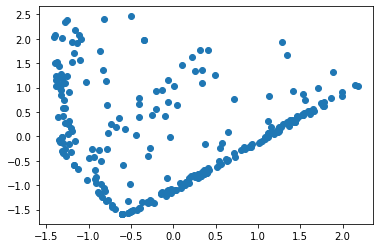

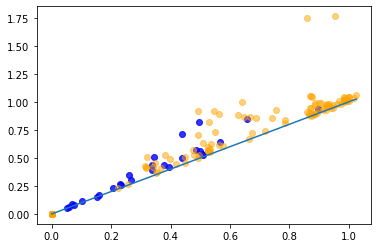

1/1 [==============================] - 5s 5s/step - loss: 1.1530
Epoch 30/30


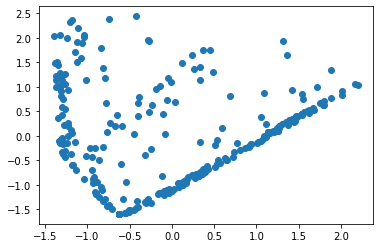

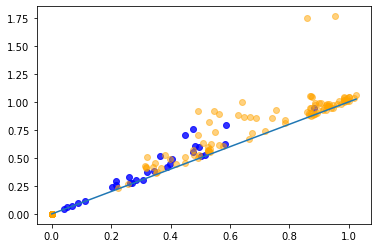

1/1 [==============================] - 6s 6s/step - loss: 1.1658


In [27]:
n_samples = 300
initial_learning_rate = 0.1
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.99,
#     staircase=True)

lr_schedule 0.1
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(2)
        ])

model.compile(loss=CustomAccuracy_norm(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=30,batch_size=n_samples)

In [55]:
n_samples = 300
initial_learning_rate = 0.1
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.99,
#     staircase=True)

lr_schedule = 0.1
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(2)
        ])

model.compile(loss=CustomAccuracy_tune(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=3,batch_size=n_samples)

Epoch 1/3
1/1 [==============================] - 5s 5s/step - loss: 1.3679
Epoch 2/3
1/1 [==============================] - 5s 5s/step - loss: 1.3679
Epoch 3/3
1/1 [==============================] - 5s 5s/step - loss: 1.3685


In [56]:
model.history.history["loss"]

[1.3678874969482422, 1.3678693771362305, 1.3684793710708618]

# Scaling

### No Scaling

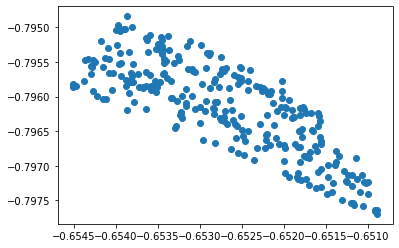

pairs [([239], [239, 93]), ([243], [243, 36]), ([225], [225, 142]), ([127], [127, 98]), ([271], [271, 113]), ([222], [222, 21]), ([169], [169, 51]), ([99], [99, 30]), ([185], [185, 168]), ([238], [238, 21]), ([253], [253, 72]), ([86], [86, 28]), ([275], [275, 87]), ([187], [187, 1]), ([159], [159, 33]), ([204], [204, 46]), ([254], [254, 181]), ([261], [261, 175]), ([278], [278, 247]), ([149], [149, 16]), ([72], [253, 108]), ([273], [273, 38]), ([251], [251, 250]), ([100], [100, 60]), ([208], [208, 21]), ([168], [185, 126]), ([140], [140, 114]), ([38], [273, 149]), ([69], [69, 17]), ([232], [232, 145]), ([263], [263, 109]), ([272], [272, 132]), ([214], [214, 156]), ([257], [257, 148]), ([148], [257, 233]), ([270], [270, 69]), ([237], [237, 39]), ([180], [180, 1]), ([93], [239, 102]), ([80], [80, 66]), ([281], [281, 93]), ([197], [197, 39]), ([136], [136, 15]), ([227], [227, 63]), ([211], [211, 63]), ([122], [122, 96]), ([212], [212, 83]), ([65], [65, 15]), ([28], [86, 23]), ([221], [221

pairs [([121, 40], [121, 40, 12]), ([144, 84], [144, 84, 0]), ([249, 144], [249, 144, 0]), ([40], [])]
indicies [249, 249, 249, 0, 144, 144, 84, 0, 121, 121, 40, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

pairs [([121, 40], [121, 40, 12]), ([144, 84], [144, 84, 0]), ([249, 144], [249, 144, 0]), ([40], [])]
indicies [249, 249, 249, 0, 144, 144, 84, 0, 121, 121, 40, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

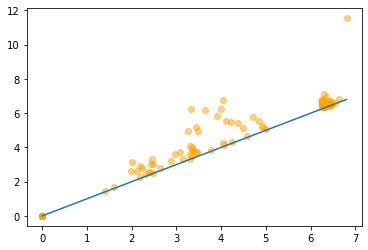

1/1 [==============================] - 3s 3s/step - loss: 39.7494


In [65]:
n_samples = 300
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])

model.compile(loss=CustomAccuracy(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

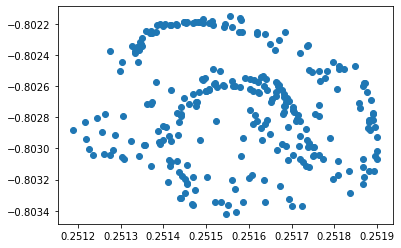

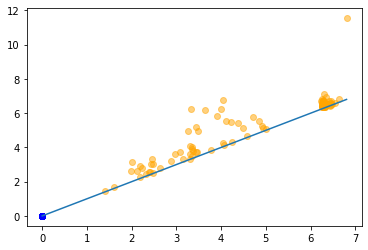

ValueError: No gradients provided for any variable: (['dense_54/kernel:0', 'dense_54/bias:0', 'dense_55/kernel:0', 'dense_55/bias:0', 'dense_56/kernel:0', 'dense_56/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_54/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.00045808,  0.03613335, -0.04680739],
       [ 0.03709549,  0.03123829, -0.01861785],
       [ 0.03469559,  0.01974097, -0.03992636]], dtype=float32)>), (None, <tf.Variable 'dense_54/bias:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>), (None, <tf.Variable 'dense_55/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.01460094, -0.01830634,  0.02121886],
       [-0.00314885,  0.04623412,  0.00683886],
       [ 0.014424  ,  0.02899343,  0.02621717]], dtype=float32)>), (None, <tf.Variable 'dense_55/bias:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>), (None, <tf.Variable 'dense_56/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.2545328 ,  0.07851398],
       [ 0.88125443, -0.24249476],
       [-0.28959733, -0.9215826 ]], dtype=float32)>), (None, <tf.Variable 'dense_56/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>)).

In [61]:
n_samples = 300
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])

model.compile(loss=CustomAccuracy_gudhi(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

### Normalizing (our PD vs. zhaoyangs PD)

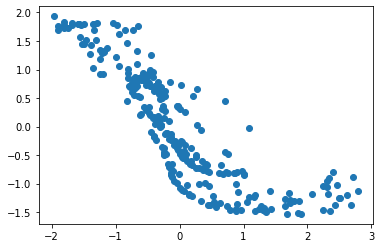

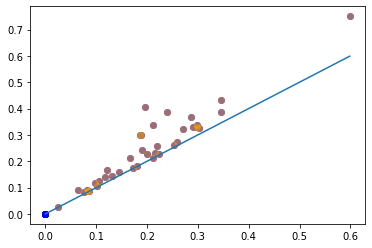

1/1 [==============================] - 7s 7s/step - loss: 1.3405


In [54]:
n_samples = 300
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])

model.compile(loss=CustomAccuracy_normalize(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

### Whitening doesn't work using Zhaoyang's code (persistent diagram is wrong)

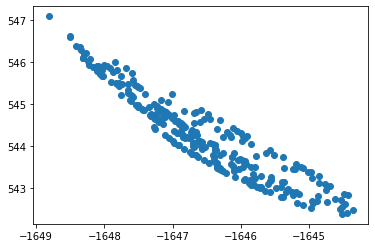

PD using gudhi [[0.05567748 0.0675797 ]
 [0.06738063 0.07143982]
 [0.07759153 0.0792447 ]
 [0.11183821 0.11499574]
 [0.11602461 0.11924265]
 [0.09838255 0.12174964]
 [0.1192247  0.12515678]
 [0.09193289 0.14017692]
 [0.14049451 0.14646089]
 [0.15265194 0.15667804]
 [0.11897293 0.1571246 ]
 [0.15735546 0.17607431]
 [0.12835838 0.17790738]
 [0.17766348 0.18033203]
 [0.17063257 0.18165691]
 [0.17186151 0.18190198]
 [0.1393786  0.18680507]
 [0.17540808 0.18940523]
 [0.18302944 0.19042127]
 [0.19073585 0.19446982]
 [0.17925796 0.19628379]
 [0.17747723 0.20467523]
 [0.16257145 0.20488931]
 [0.1634449  0.20721255]
 [0.1981499  0.21649511]
 [0.14317141 0.22655675]
 [0.21763964 0.23743005]
 [0.14304267 0.23767266]
 [0.17771095 0.24165101]
 [0.16448651 0.25551343]
 [0.20790298 0.26182908]
 [0.16783786 0.26245153]
 [0.2862502  0.28704   ]
 [0.2684115  0.2871895 ]
 [0.17267837 0.29984367]
 [0.3155065  0.34050685]
 [0.20574063 0.3547482 ]
 [0.28932405 0.39368853]
 [0.2936316  0.42158976]
 [0.248124

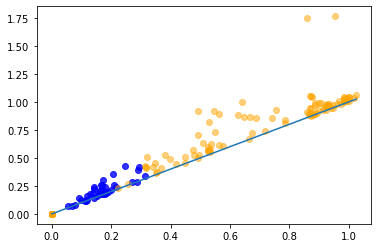

PD using zhaoyang [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 

In [52]:
n_samples = 300
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])

model.compile(loss=CustomAccuracy_whiten(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

# 1 Cylinder

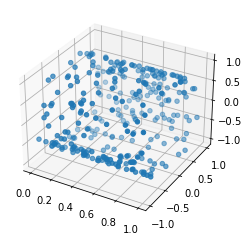

In [99]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

# Whitening

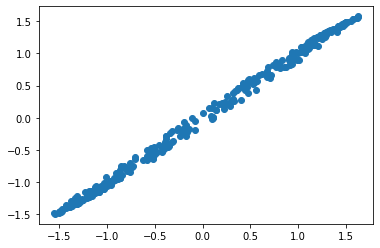

x <class 'numpy.ndarray'>
x <class 'numpy.ndarray'>


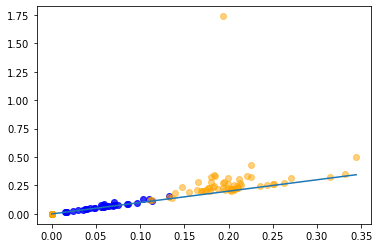

1/1 [==============================] - 6s 6s/step - loss: 1.3276


In [63]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy_whiten(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

### Normalizing

Epoch 1/5


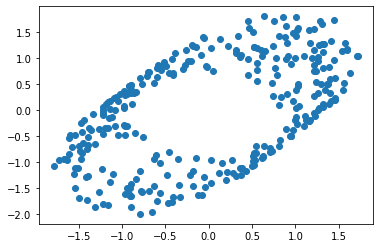

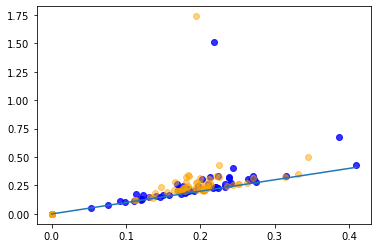

1/1 [==============================] - 7s 7s/step - loss: 0.1096
Epoch 2/5


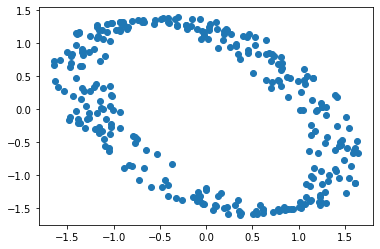

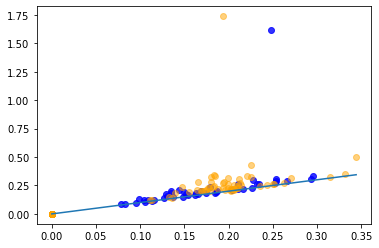

1/1 [==============================] - 7s 7s/step - loss: 0.1036
Epoch 3/5


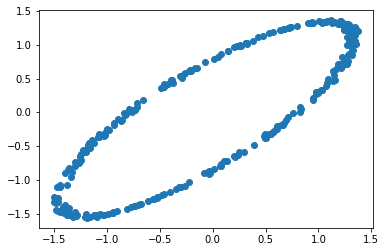

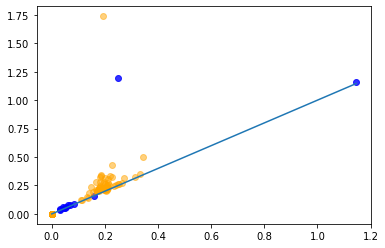

1/1 [==============================] - 7s 7s/step - loss: 0.4310
Epoch 4/5


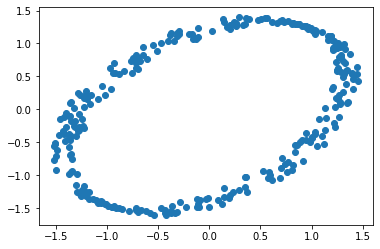

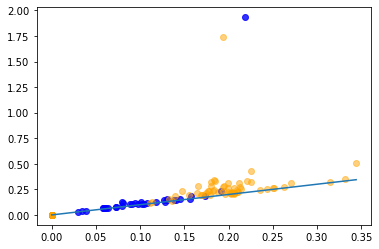

1/1 [==============================] - 7s 7s/step - loss: 0.1726
Epoch 5/5


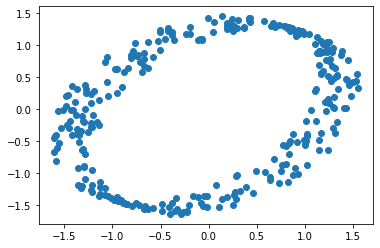

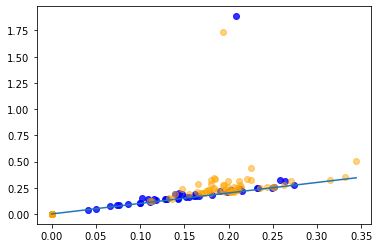

1/1 [==============================] - 8s 8s/step - loss: 0.1306


In [35]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

### Random Uniform initial weights with learning rate = 0.2

Observation: lower than 0.2 learning rate performed better

Epoch 1/5


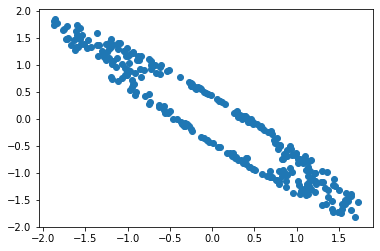

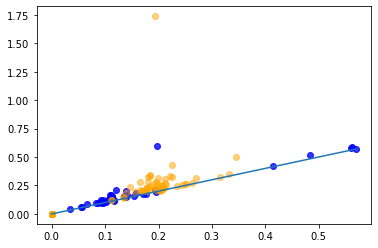

1/1 [==============================] - 7s 7s/step - loss: 1.3316
Epoch 2/5


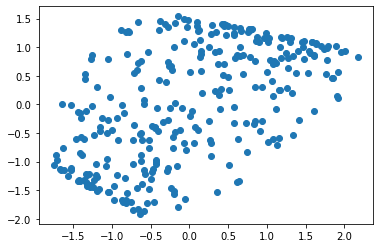

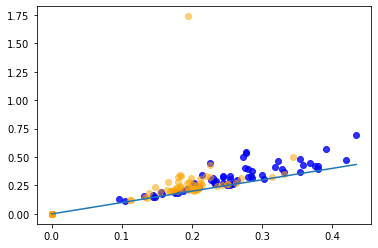

1/1 [==============================] - 7s 7s/step - loss: 1.2992
Epoch 3/5


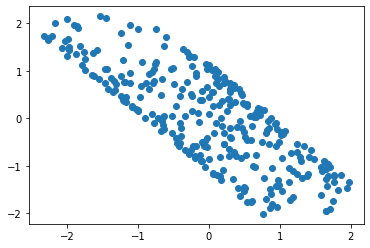

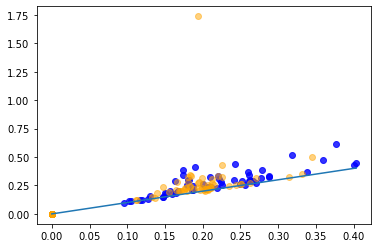

1/1 [==============================] - 7s 7s/step - loss: 1.2604
Epoch 4/5


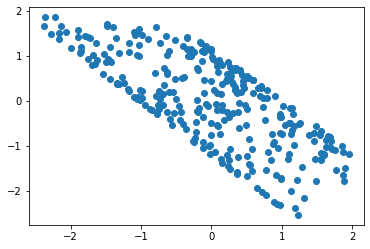

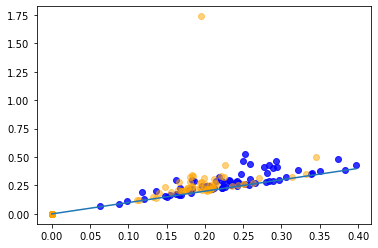

1/1 [==============================] - 8s 8s/step - loss: 1.2918
Epoch 5/5


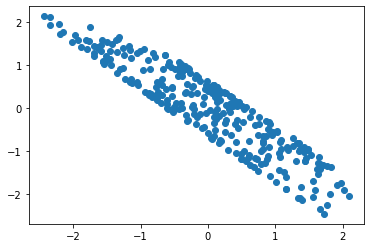

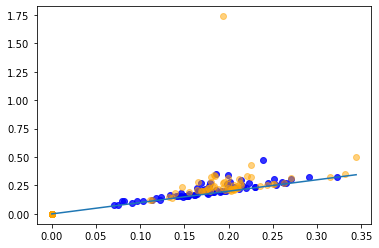

1/1 [==============================] - 7s 7s/step - loss: 1.2280


In [38]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

### Normalizing + Adjust for Dimension

Observation: Scale is off

Epoch 1/5


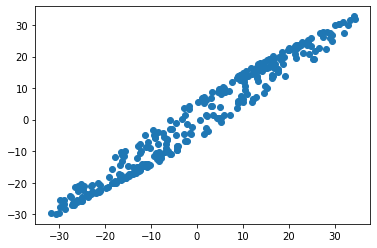

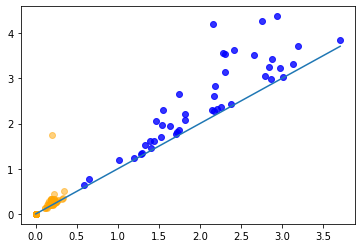

1/1 [==============================] - 4s 4s/step - loss: 10.4017
Epoch 2/5


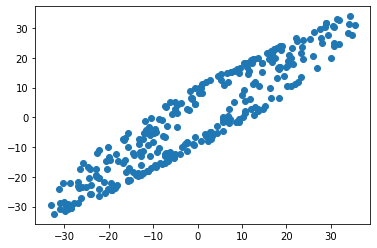

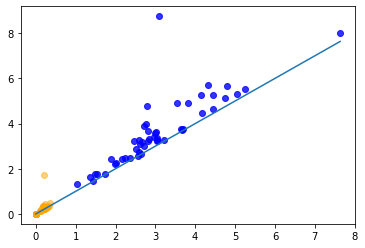

1/1 [==============================] - 4s 4s/step - loss: 26.8536
Epoch 3/5


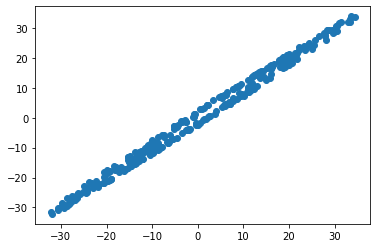

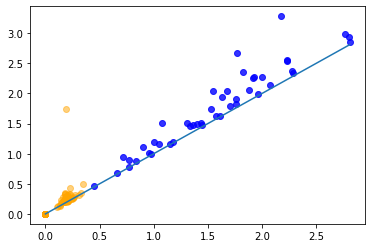

1/1 [==============================] - 4s 4s/step - loss: 2.8438
Epoch 4/5


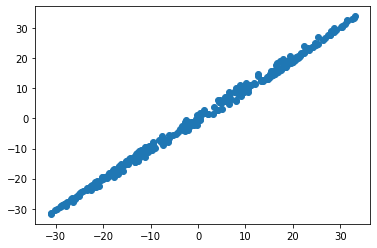

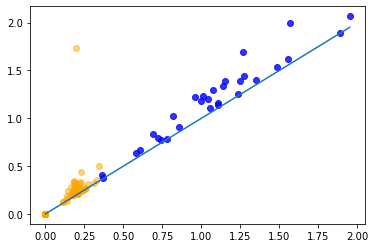

1/1 [==============================] - 4s 4s/step - loss: 1.3738
Epoch 5/5


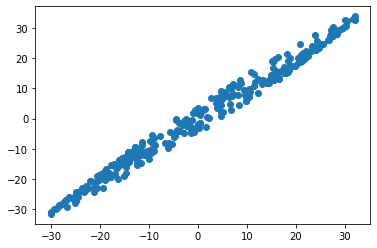

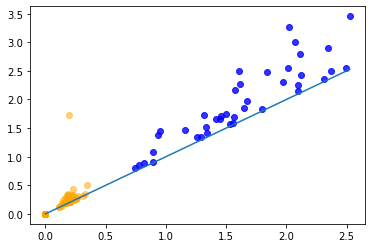

1/1 [==============================] - 4s 4s/step - loss: 4.5214


In [31]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

### Random Normal initial weights  with learning rate = 0.2

Observation: 

* Random Normal intial weights performs better with higher learning rate
* Random Uniform initial weights performs better with lower learning rate



Epoch 1/5


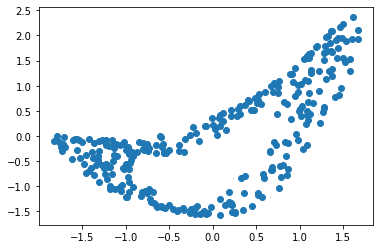

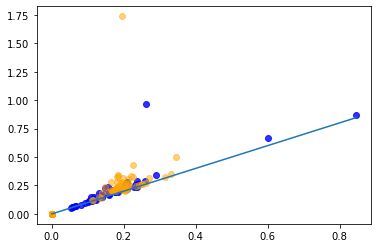

1/1 [==============================] - 7s 7s/step - loss: 0.6827
Epoch 2/5


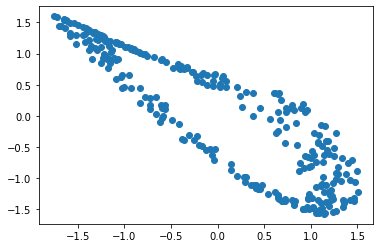

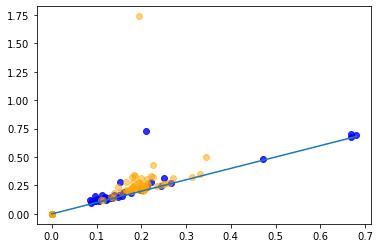

1/1 [==============================] - 7s 7s/step - loss: 1.1242
Epoch 3/5


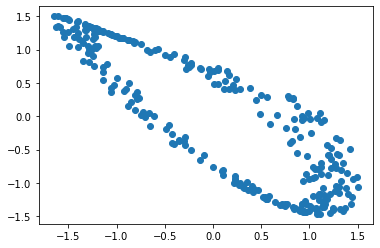

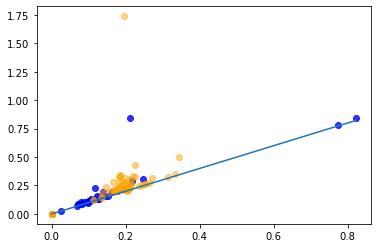

1/1 [==============================] - 7s 7s/step - loss: 0.9081
Epoch 4/5


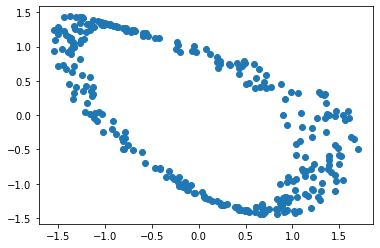

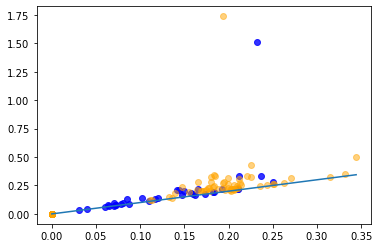

1/1 [==============================] - 7s 7s/step - loss: 0.1542
Epoch 5/5


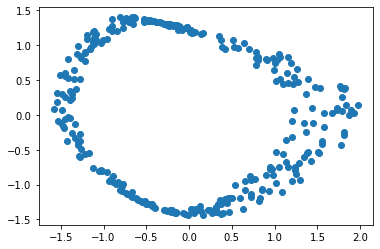

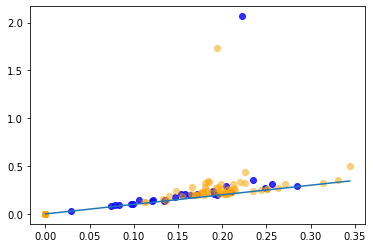

1/1 [==============================] - 7s 7s/step - loss: 0.1991


In [37]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

## Random Normal (learning rate = 0.2) vs. Random Uniform (learning rate = 0.01)

These are not the optimal parameters.

Epoch 1/50


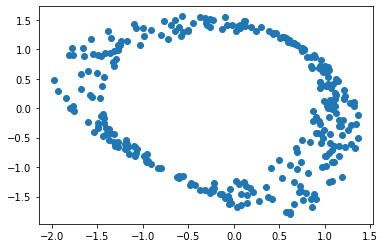

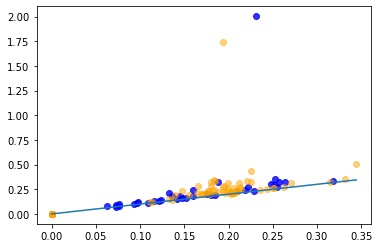

1/1 [==============================] - 8s 8s/step - loss: 0.1416
Epoch 2/50


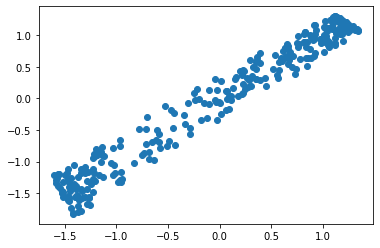

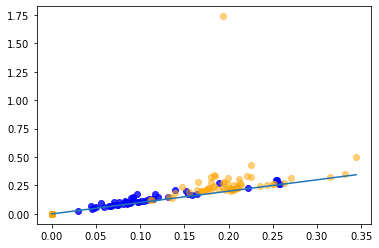

1/1 [==============================] - 8s 8s/step - loss: 1.3111
Epoch 3/50


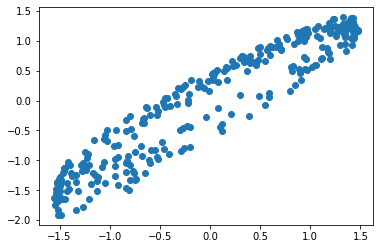

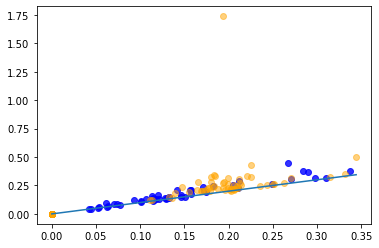

1/1 [==============================] - 8s 8s/step - loss: 1.2750
Epoch 4/50


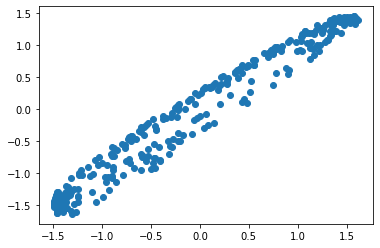

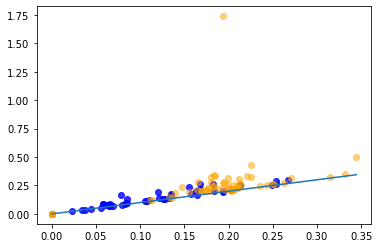

1/1 [==============================] - 8s 8s/step - loss: 1.2952
Epoch 5/50


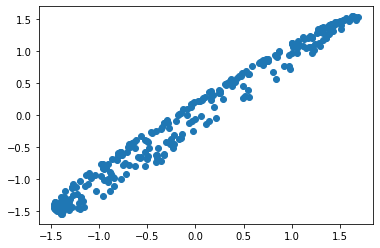

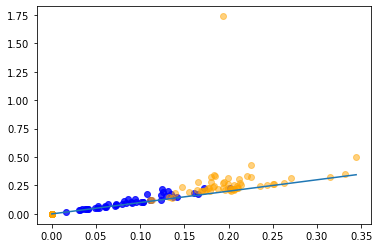

1/1 [==============================] - 7s 7s/step - loss: 1.3212
Epoch 6/50


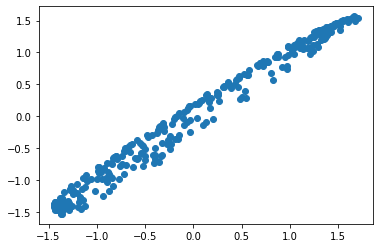

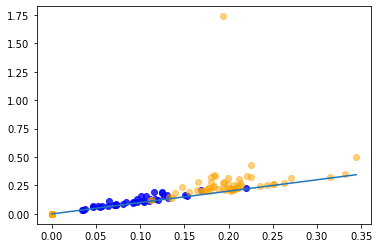

1/1 [==============================] - 7s 7s/step - loss: 1.3284
Epoch 7/50


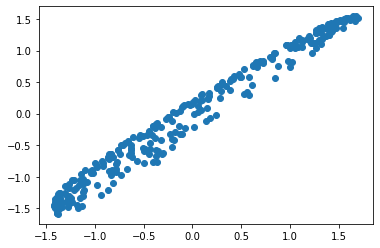

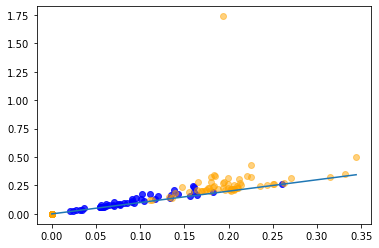

1/1 [==============================] - 7s 7s/step - loss: 1.3182
Epoch 8/50


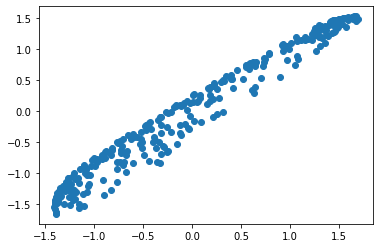

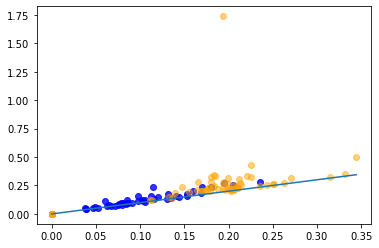

1/1 [==============================] - 7s 7s/step - loss: 1.3003
Epoch 9/50


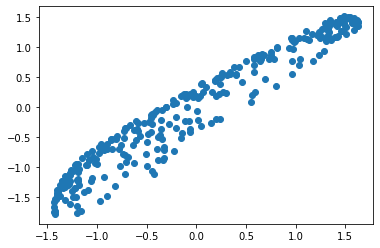

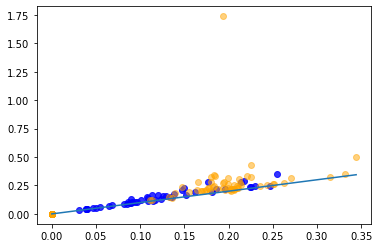

1/1 [==============================] - 7s 7s/step - loss: 1.2783
Epoch 10/50


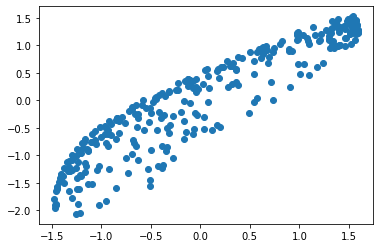

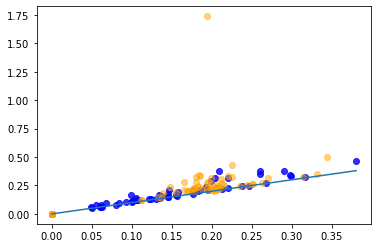

1/1 [==============================] - 7s 7s/step - loss: 1.2477
Epoch 11/50


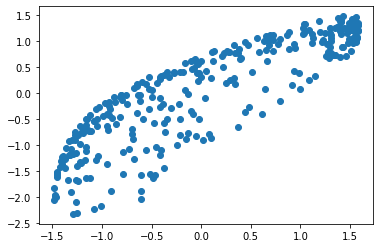

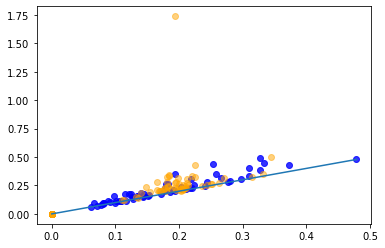

1/1 [==============================] - 7s 7s/step - loss: 1.2525
Epoch 12/50


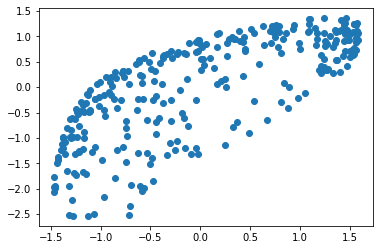

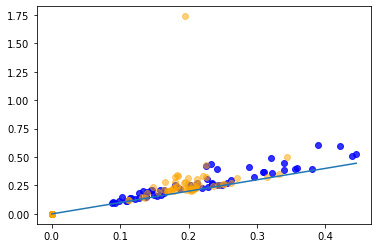

1/1 [==============================] - 7s 7s/step - loss: 1.3024
Epoch 13/50


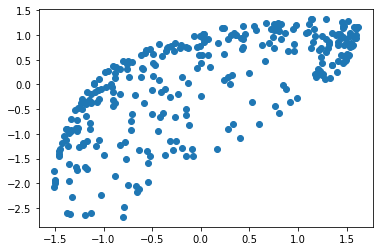

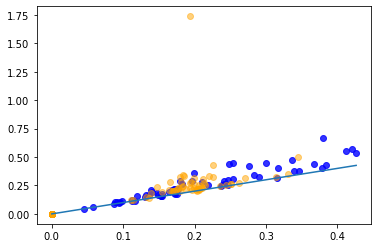

1/1 [==============================] - 7s 7s/step - loss: 1.2771
Epoch 14/50


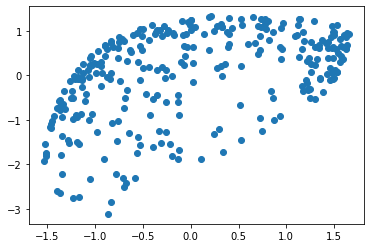

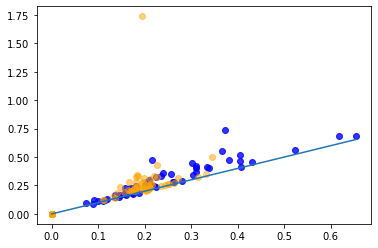

1/1 [==============================] - 7s 7s/step - loss: 1.1042
Epoch 15/50


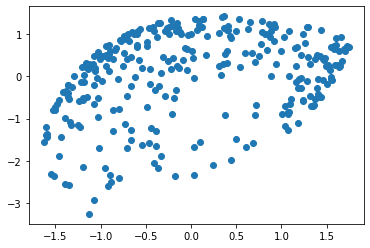

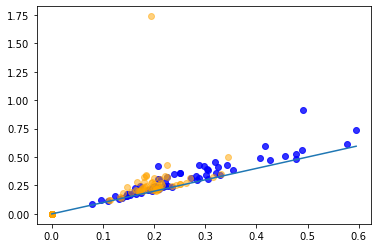

1/1 [==============================] - 7s 7s/step - loss: 0.8705
Epoch 16/50


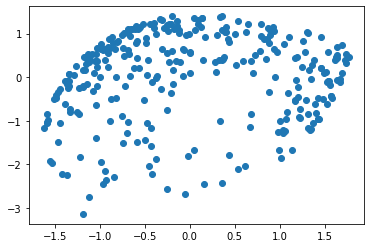

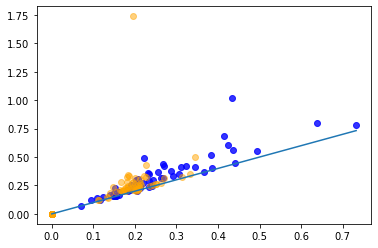

1/1 [==============================] - 7s 7s/step - loss: 0.7183
Epoch 17/50


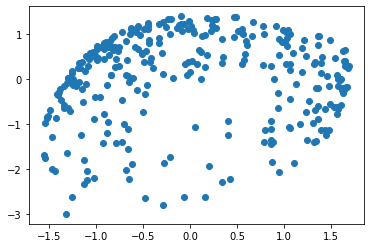

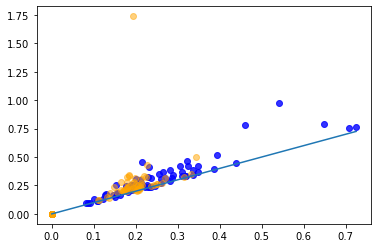

1/1 [==============================] - 7s 7s/step - loss: 0.8301
Epoch 18/50


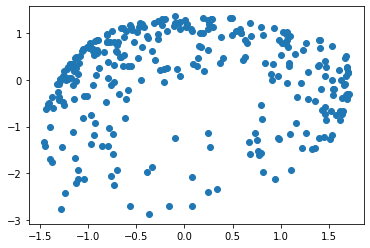

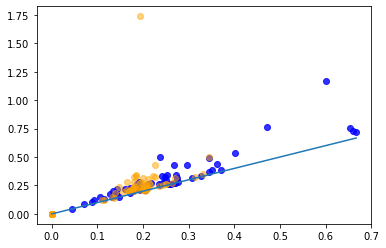

1/1 [==============================] - 7s 7s/step - loss: 0.6146
Epoch 19/50


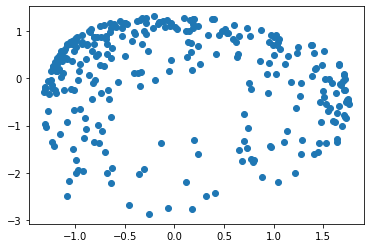

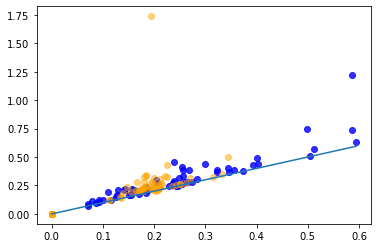

1/1 [==============================] - 7s 7s/step - loss: 0.5389
Epoch 20/50


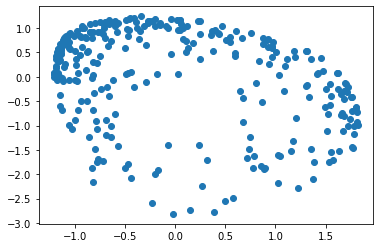

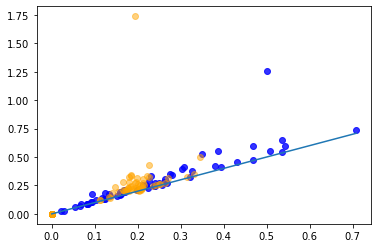

1/1 [==============================] - 7s 7s/step - loss: 0.4246
Epoch 21/50


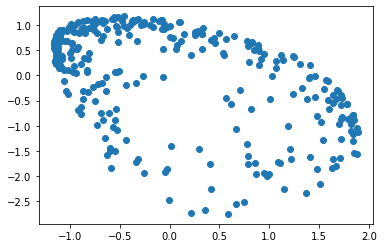

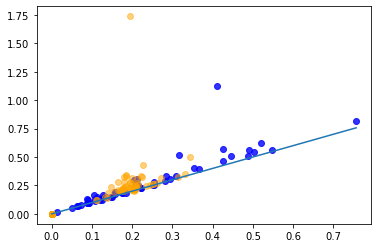

1/1 [==============================] - 7s 7s/step - loss: 0.5195
Epoch 22/50


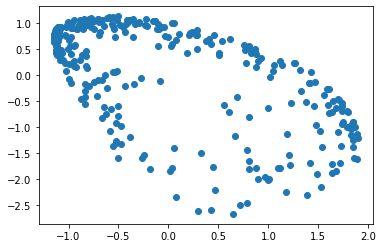

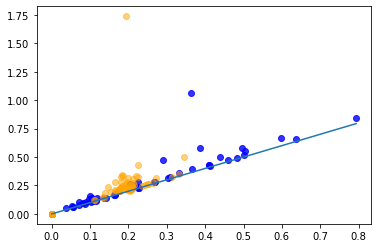

1/1 [==============================] - 8s 8s/step - loss: 0.5866
Epoch 23/50


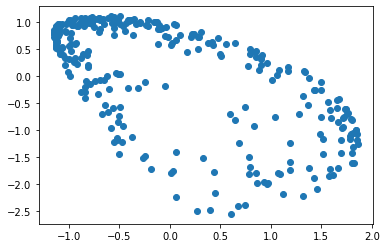

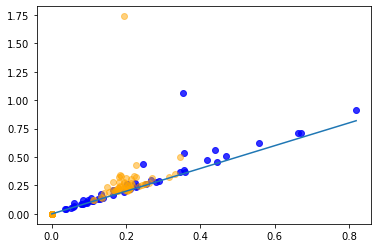

1/1 [==============================] - 8s 8s/step - loss: 0.5798
Epoch 24/50


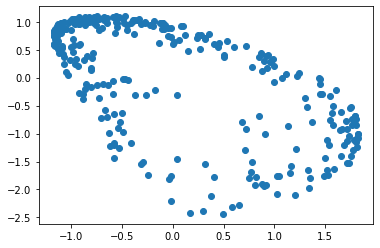

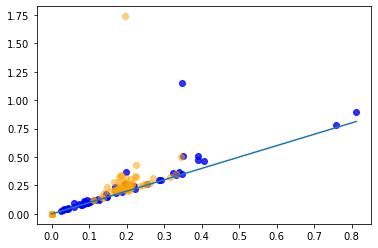

1/1 [==============================] - 7s 7s/step - loss: 0.4735
Epoch 25/50


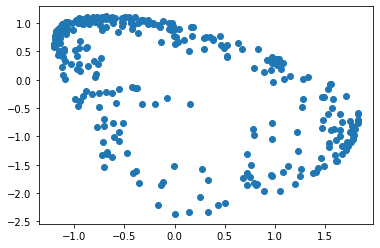

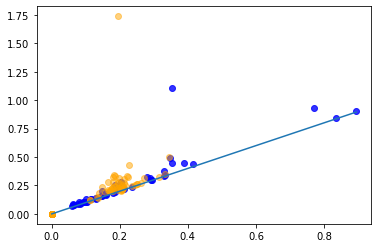

1/1 [==============================] - 7s 7s/step - loss: 0.5265
Epoch 26/50


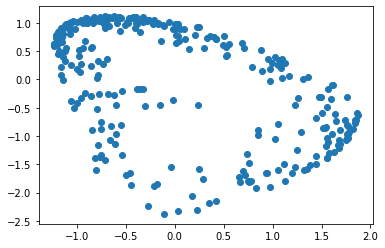

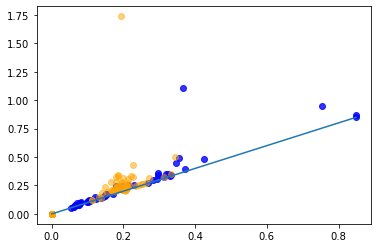

1/1 [==============================] - 7s 7s/step - loss: 0.5435
Epoch 27/50


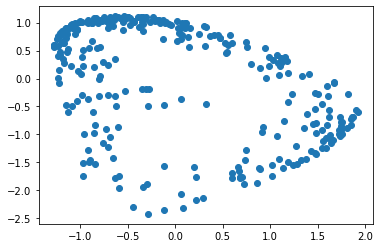

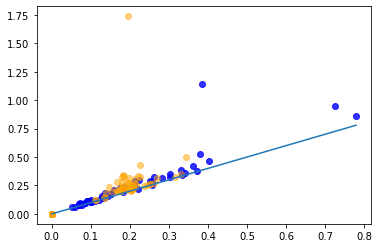

1/1 [==============================] - 7s 7s/step - loss: 0.4985
Epoch 28/50


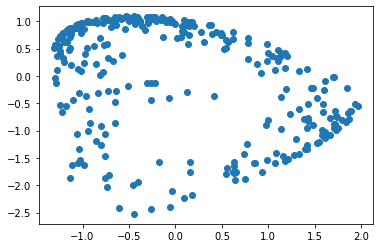

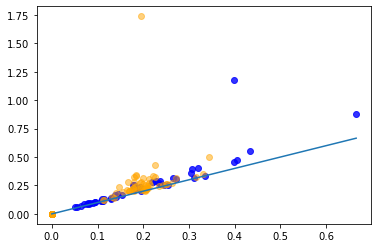

1/1 [==============================] - 8s 8s/step - loss: 0.4524
Epoch 29/50


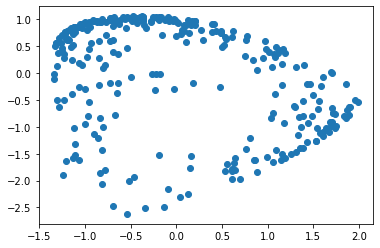

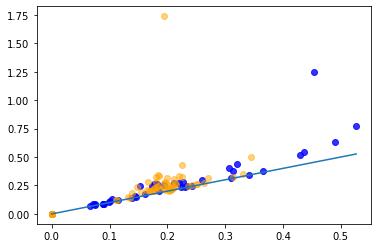

1/1 [==============================] - 7s 7s/step - loss: 0.4279
Epoch 30/50


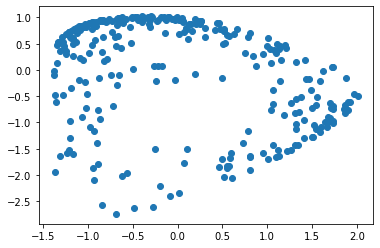

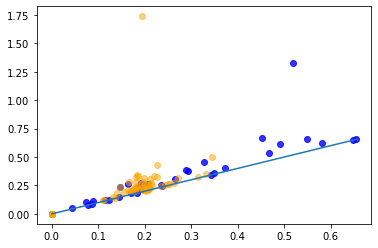

1/1 [==============================] - 7s 7s/step - loss: 0.3807
Epoch 31/50


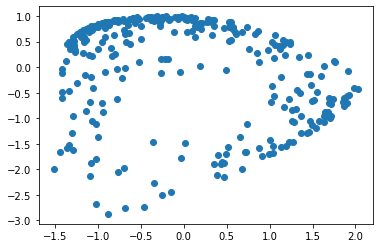

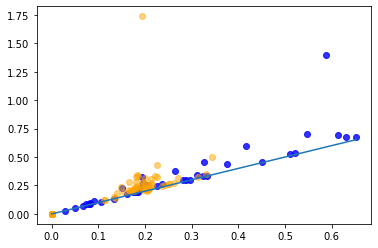

1/1 [==============================] - 7s 7s/step - loss: 0.3726
Epoch 32/50


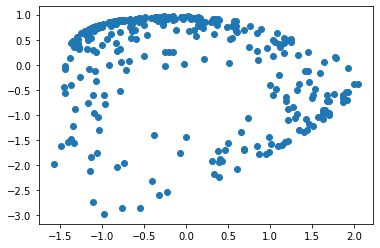

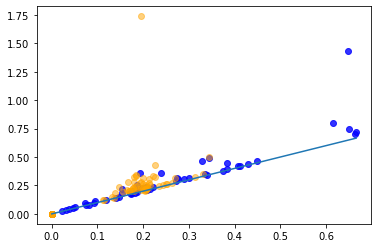

1/1 [==============================] - 7s 7s/step - loss: 0.3901
Epoch 33/50


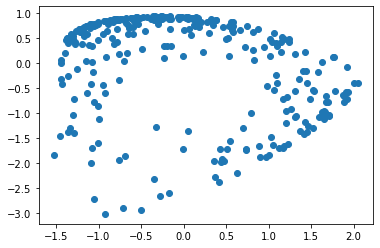

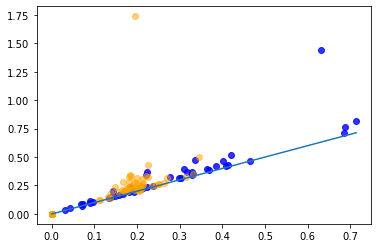

1/1 [==============================] - 8s 8s/step - loss: 0.3659
Epoch 34/50


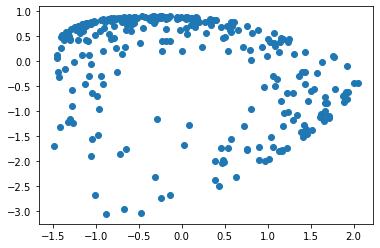

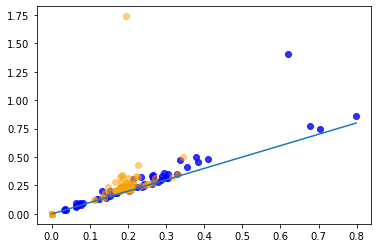

1/1 [==============================] - 7s 7s/step - loss: 0.3749
Epoch 35/50


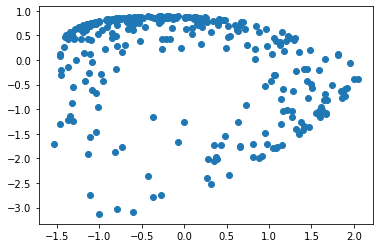

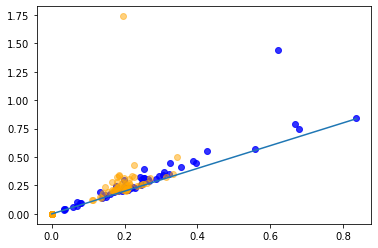

1/1 [==============================] - 8s 8s/step - loss: 0.3503
Epoch 36/50


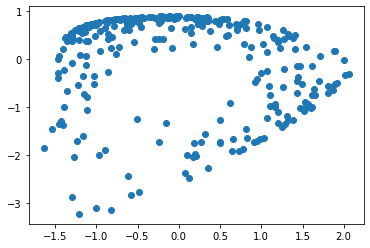

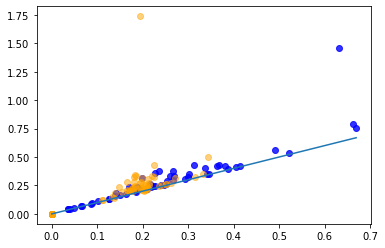

1/1 [==============================] - 7s 7s/step - loss: 0.3413
Epoch 37/50


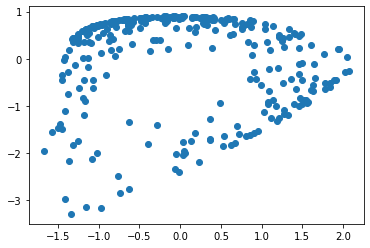

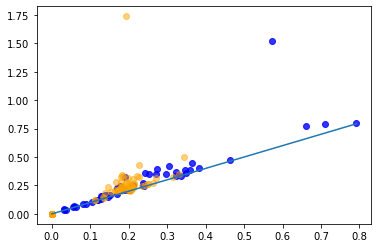

1/1 [==============================] - 7s 7s/step - loss: 0.2622
Epoch 38/50


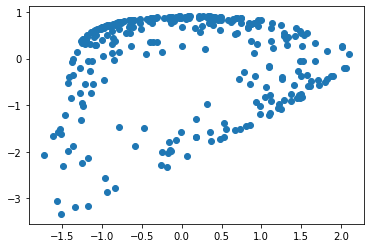

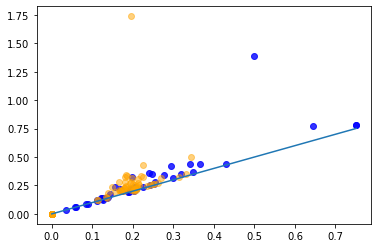

1/1 [==============================] - 7s 7s/step - loss: 0.2846
Epoch 39/50


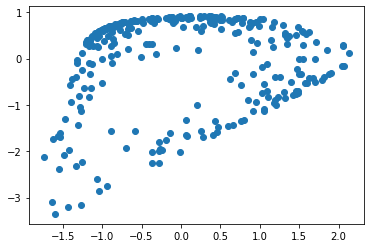

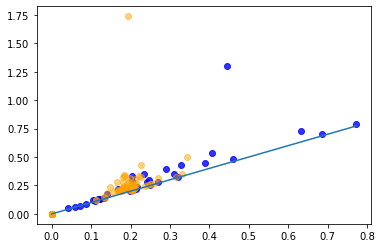

1/1 [==============================] - 7s 7s/step - loss: 0.3261
Epoch 40/50


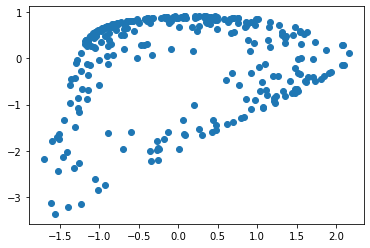

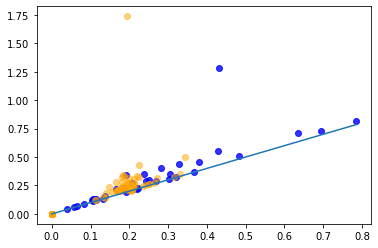

1/1 [==============================] - 7s 7s/step - loss: 0.3363
Epoch 41/50


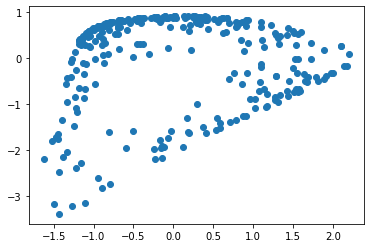

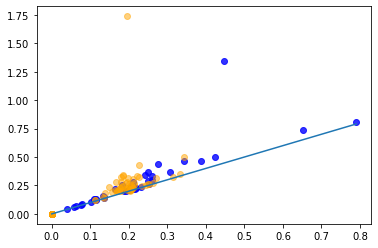

1/1 [==============================] - 8s 8s/step - loss: 0.2855
Epoch 42/50


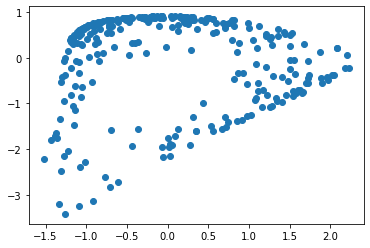

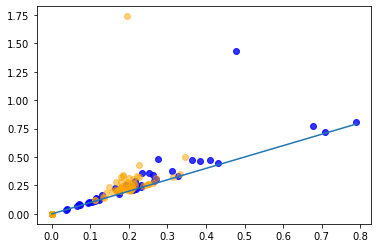

1/1 [==============================] - 7s 7s/step - loss: 0.2401
Epoch 43/50


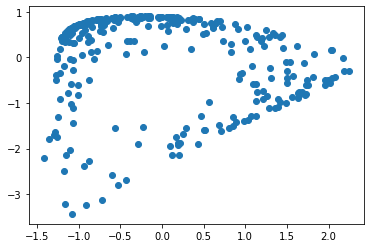

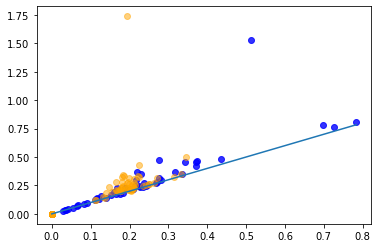

1/1 [==============================] - 7s 7s/step - loss: 0.2202
Epoch 44/50


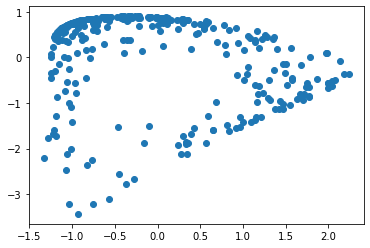

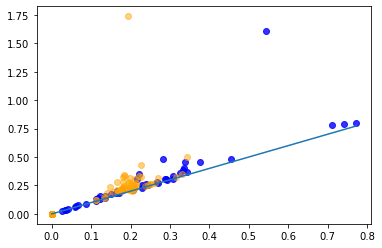

1/1 [==============================] - 8s 8s/step - loss: 0.2241
Epoch 45/50


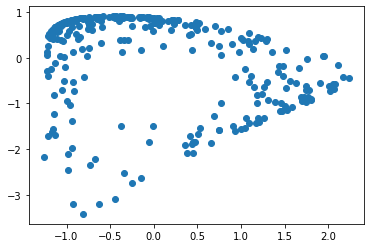

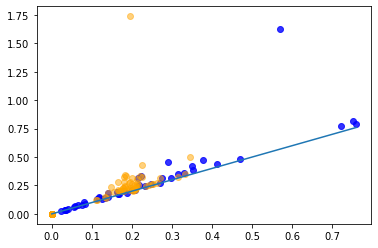

1/1 [==============================] - 7s 7s/step - loss: 0.2347
Epoch 46/50


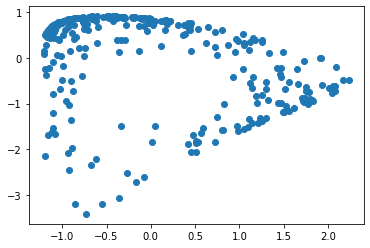

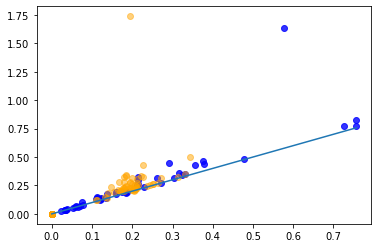

1/1 [==============================] - 7s 7s/step - loss: 0.2369
Epoch 47/50


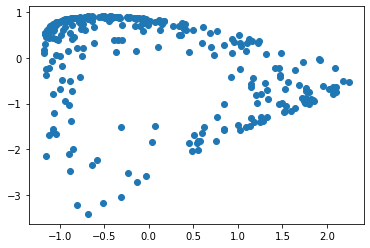

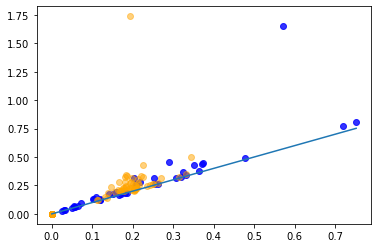

1/1 [==============================] - 7s 7s/step - loss: 0.2323
Epoch 48/50


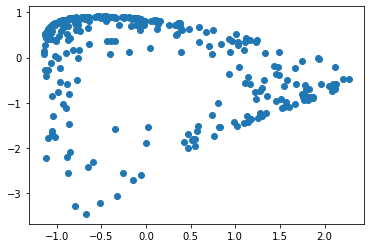

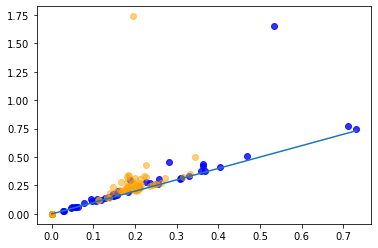

1/1 [==============================] - 7s 7s/step - loss: 0.2033
Epoch 49/50


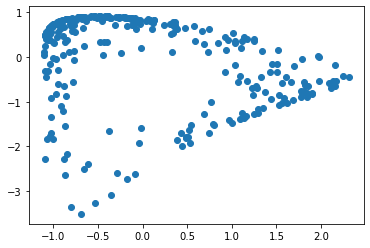

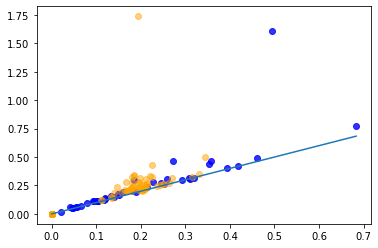

1/1 [==============================] - 7s 7s/step - loss: 0.1933
Epoch 50/50


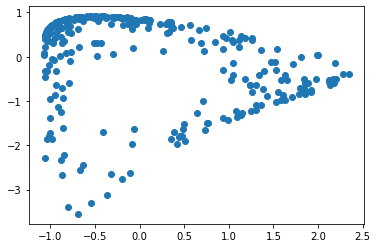

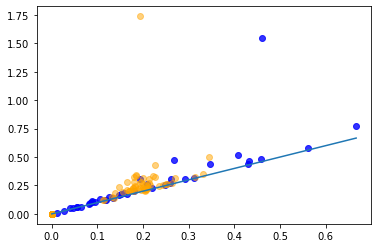

1/1 [==============================] - 7s 7s/step - loss: 0.1989


In [58]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=50,batch_size=n_samples)

Question: The projection is making a hole. How do we know the hole is in the right place?

### Relu Activation Function

Epoch 1/5


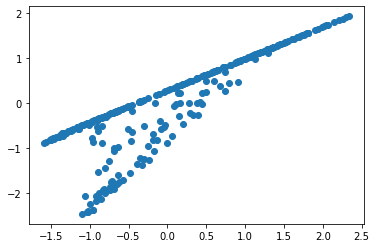

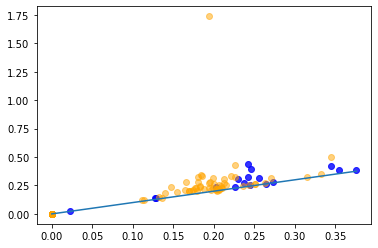

1/1 [==============================] - 7s 7s/step - loss: 1.2651
Epoch 2/5


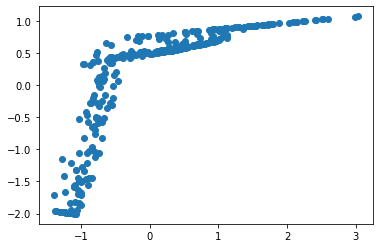

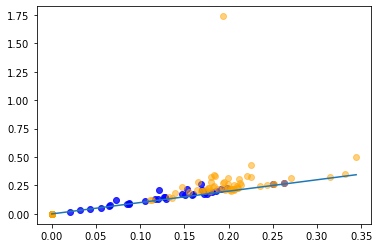

1/1 [==============================] - 7s 7s/step - loss: 1.3072
Epoch 3/5


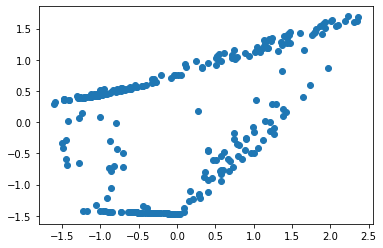

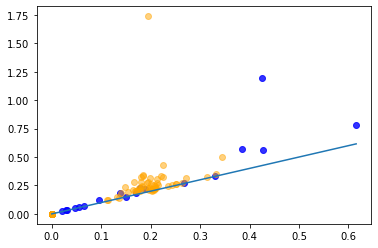

1/1 [==============================] - 7s 7s/step - loss: 0.4933
Epoch 4/5


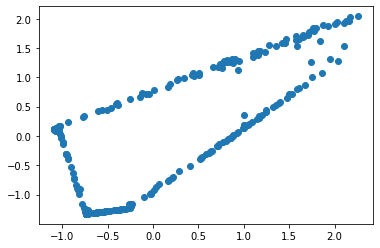

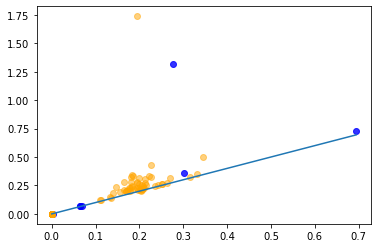

1/1 [==============================] - 7s 7s/step - loss: 0.3127
Epoch 5/5


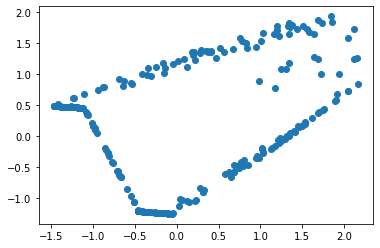

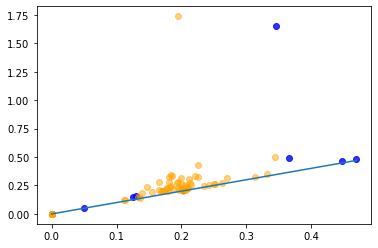

1/1 [==============================] - 7s 7s/step - loss: 0.1527


In [39]:
n_samples = 300

initial_learning_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='relu', 
                              kernel_initializer=initializers.RandomNormal(stddev=1),  
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

### Layers

1 Hidden Layer

Epoch 1/5


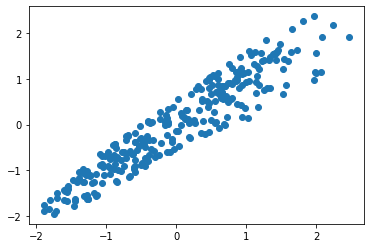

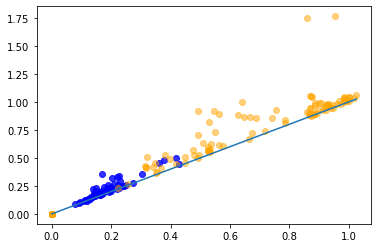

1/1 [==============================] - 5s 5s/step - loss: 1.3974
Epoch 2/5


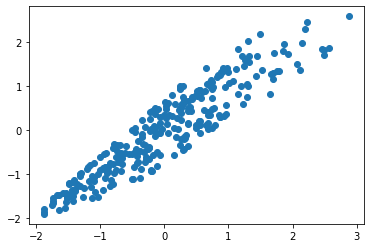

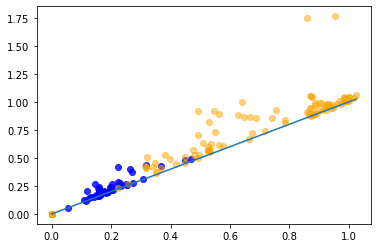

1/1 [==============================] - 5s 5s/step - loss: 1.3744
Epoch 3/5


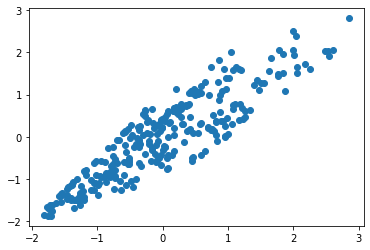

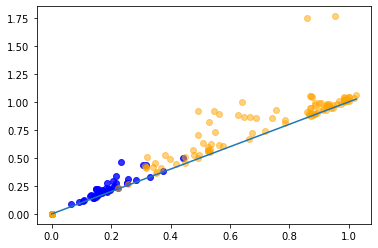

1/1 [==============================] - 5s 5s/step - loss: 1.3737
Epoch 4/5


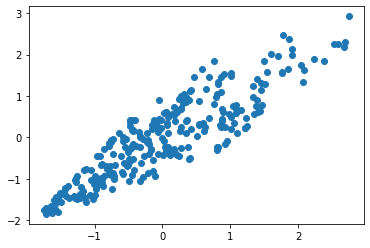

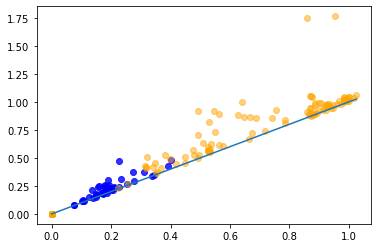

1/1 [==============================] - 5s 5s/step - loss: 1.3788
Epoch 5/5


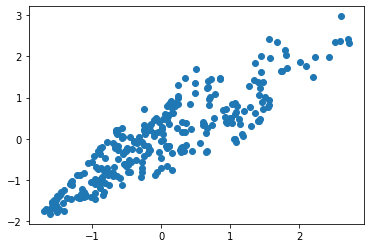

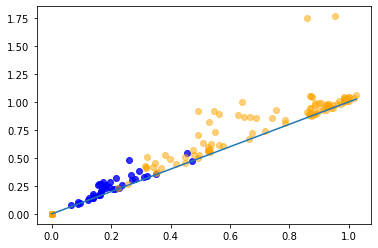

1/1 [==============================] - 5s 5s/step - loss: 1.3978


In [29]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy_norm(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

2 layers

Epoch 1/5


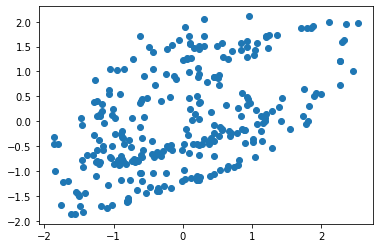

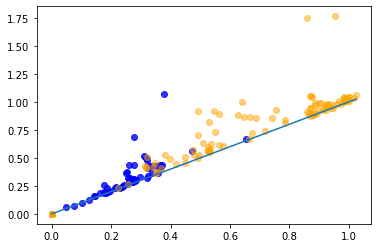

1/1 [==============================] - 5s 5s/step - loss: 1.3231
Epoch 2/5


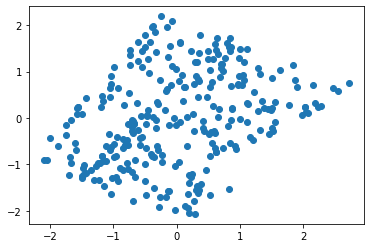

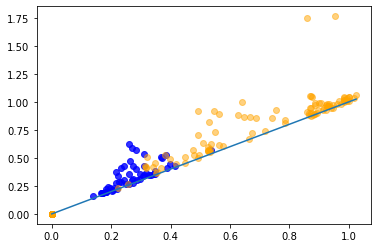

1/1 [==============================] - 5s 5s/step - loss: 1.4546
Epoch 3/5


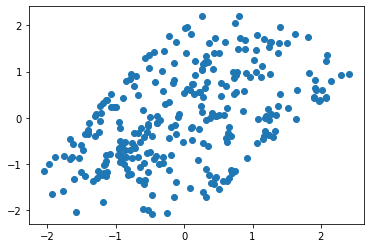

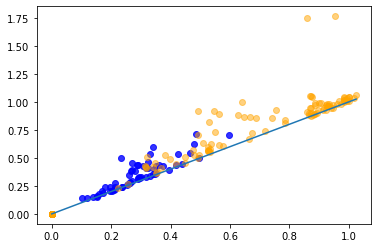

1/1 [==============================] - 5s 5s/step - loss: 1.2892
Epoch 4/5


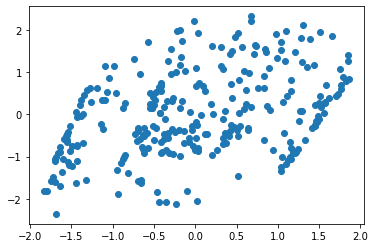

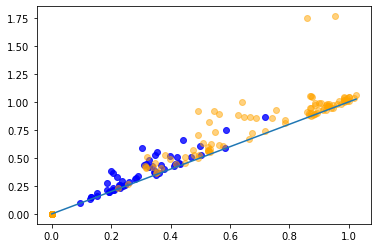

1/1 [==============================] - 5s 5s/step - loss: 1.2587
Epoch 5/5


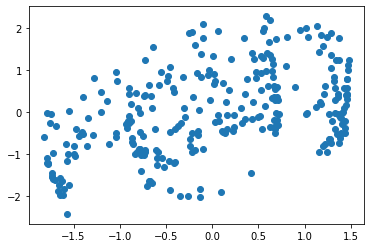

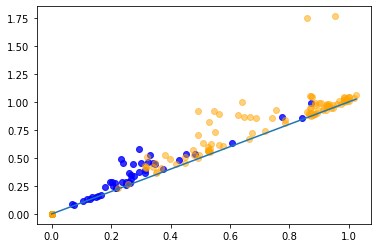

1/1 [==============================] - 5s 5s/step - loss: 1.3312


In [31]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy_norm(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

3 Hidden Layers

Epoch 1/5


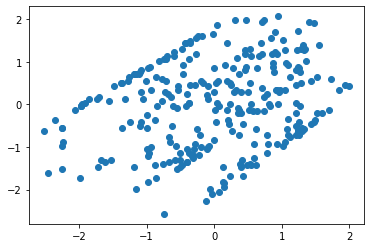

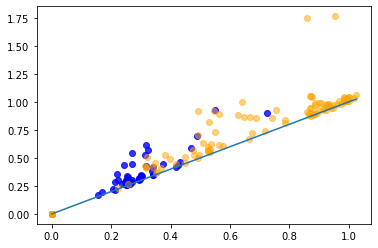

1/1 [==============================] - 5s 5s/step - loss: 1.2129
Epoch 2/5


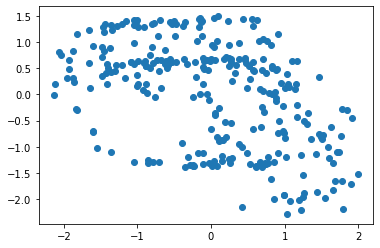

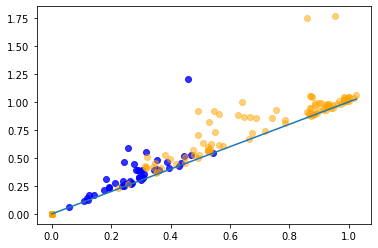

1/1 [==============================] - 5s 5s/step - loss: 1.3548
Epoch 3/5


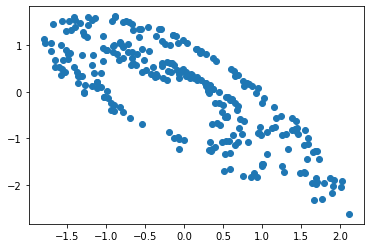

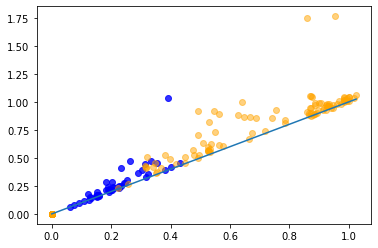

1/1 [==============================] - 5s 5s/step - loss: 1.2866
Epoch 4/5


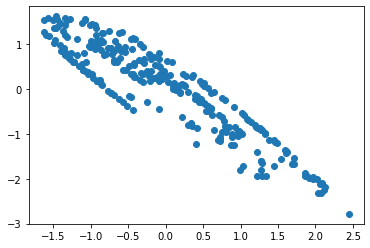

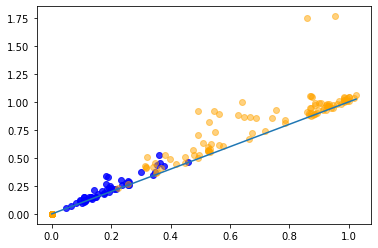

1/1 [==============================] - 5s 5s/step - loss: 1.3702
Epoch 5/5


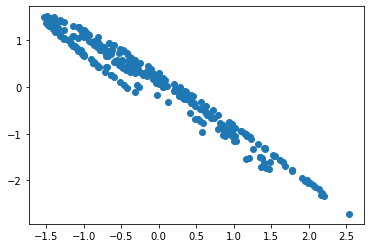

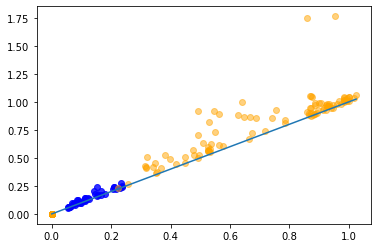

1/1 [==============================] - 5s 5s/step - loss: 1.3806


In [32]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),    
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy_norm(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

Looks Good!

### 4 Hidden Layers

TERRIBLE?!?!?!

Epoch 1/5


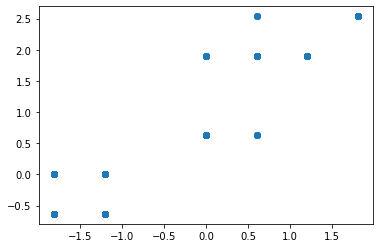

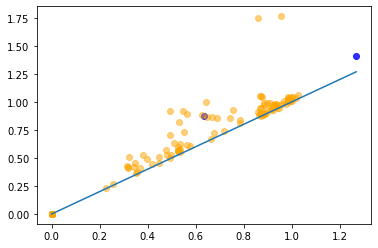

1/1 [==============================] - 5s 5s/step - loss: 1.1895
Epoch 2/5


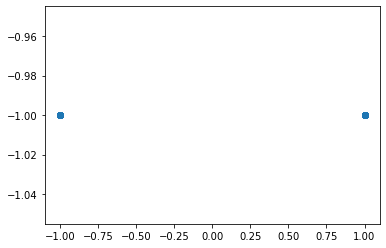

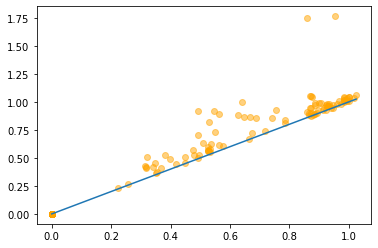

1/1 [==============================] - 5s 5s/step - loss: 1.3677
Epoch 3/5


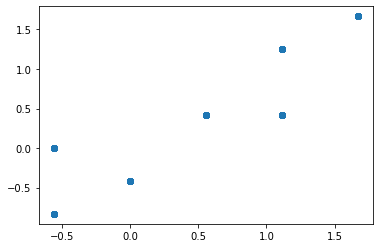

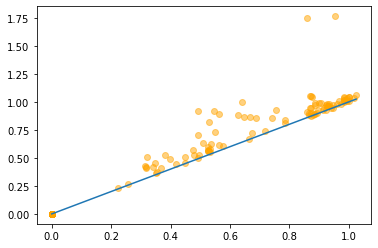

1/1 [==============================] - 5s 5s/step - loss: 1.3677
Epoch 4/5


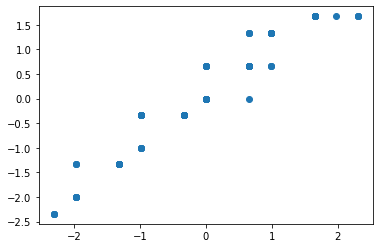

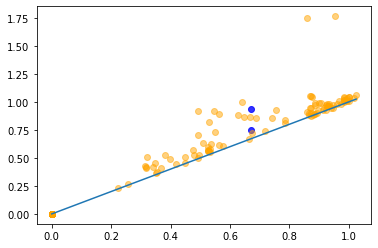

1/1 [==============================] - 5s 5s/step - loss: 1.2773
Epoch 5/5


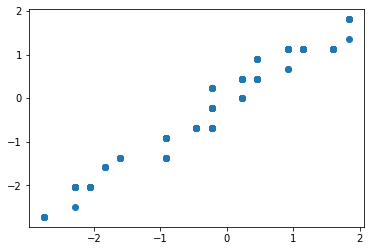

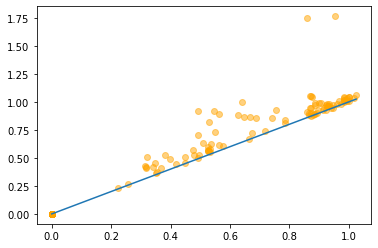

1/1 [==============================] - 5s 5s/step - loss: 1.3677


In [33]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),    
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy_norm(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=5,batch_size=n_samples)

# 2 Cylinder

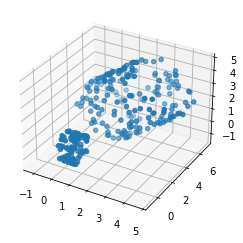

In [15]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back

ss3=np.random.uniform(0,2*np.pi,100)
noise=np.random.normal(0,0.1,150) #add noise if you want

#small cylinder
noise=0 #cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)




rr3=np.random.uniform(0,1,100) 

np.random.seed(100)
sss3=np.random.uniform(0,2*np.pi,200)
xxx=3+2*np.cos(sss3)
yyy=2*np.sin(sss3)


xxx45=2+xxx #how far apart the cylinders are 


rrr3=np.random.uniform(0,5,200) 

#rotate by 45 degree
rrr45=rrr3*np.sqrt(2)/2-np.sqrt(2)/2*yyy
yyy45=rrr3*np.sqrt(2)/2+np.sqrt(2)/2*yyy


#np.r_ concatenate 
RR=np.r_[rr3,rrr45]  #points on one axis
RX=np.r_[xx,xxx] #not used
RY=np.r_[yy,yyy] #not used

RX45=np.r_[xx,xxx45] #points on one axis
RY45=np.r_[yy,yyy45] #points on one axis

ax = plt.subplot(111, projection='3d')
X=np.array(np.mat([RR,RX45,RY45]).T,dtype=np.float32)
ax.scatter(X[:,0],X[:,1],X[:,2]) 
plt.show()

In [16]:
X.shape

(300, 3)

Epoch 1/10


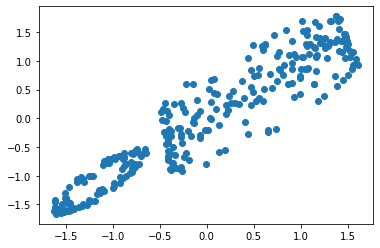

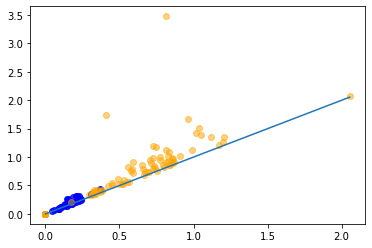

1/1 [==============================] - 6s 6s/step - loss: 5.6924
Epoch 2/10


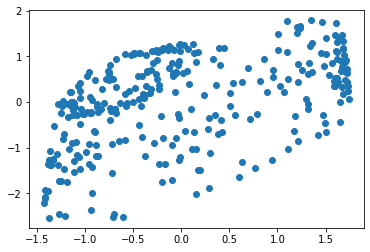

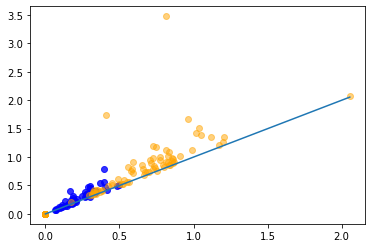

1/1 [==============================] - 7s 7s/step - loss: 5.7232
Epoch 3/10


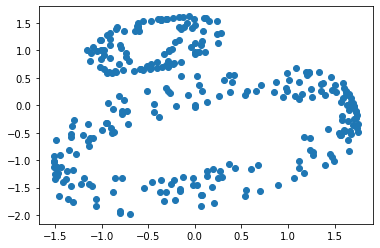

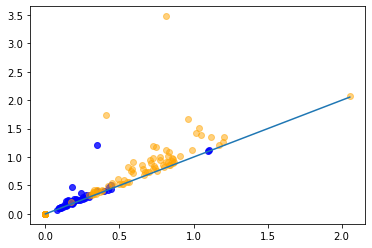

1/1 [==============================] - 7s 7s/step - loss: 5.0856
Epoch 4/10


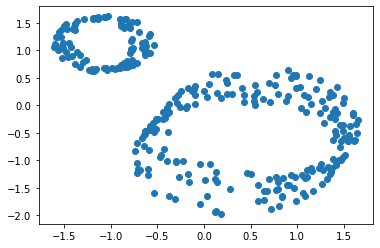

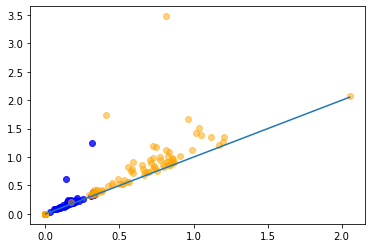

1/1 [==============================] - 7s 7s/step - loss: 5.1099
Epoch 5/10


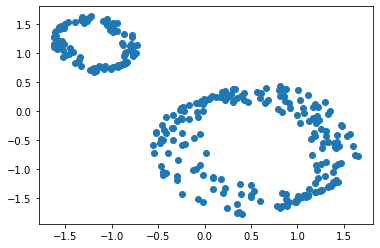

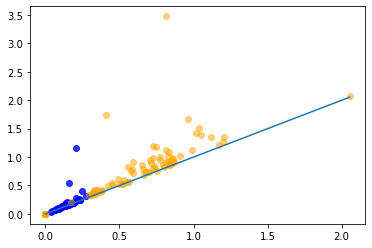

1/1 [==============================] - 7s 7s/step - loss: 5.2089
Epoch 6/10


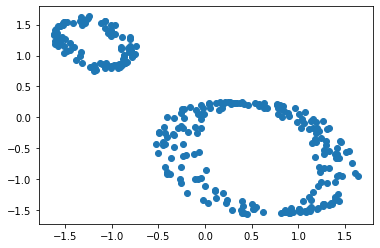

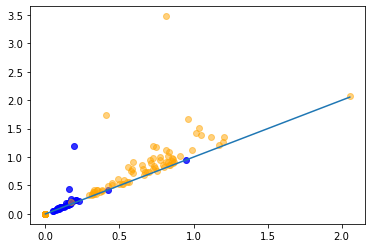

1/1 [==============================] - 7s 7s/step - loss: 5.1449
Epoch 7/10


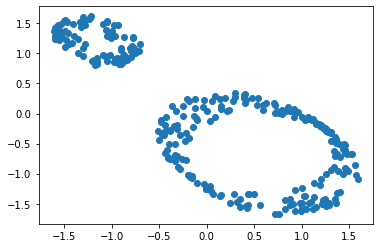

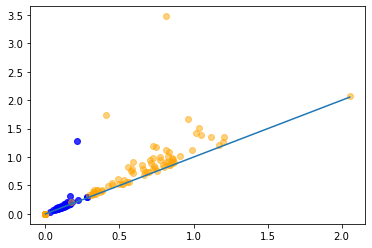

1/1 [==============================] - 7s 7s/step - loss: 5.0325
Epoch 8/10


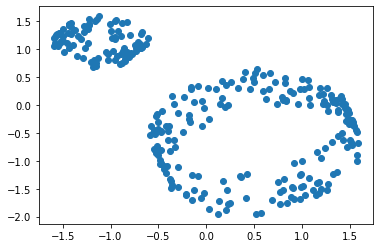

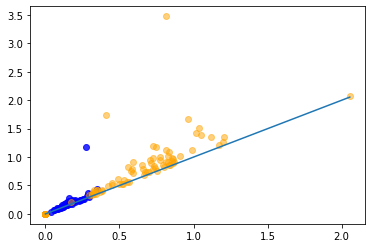

1/1 [==============================] - 7s 7s/step - loss: 5.1237
Epoch 9/10


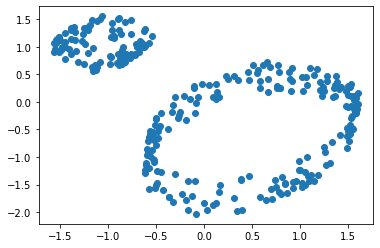

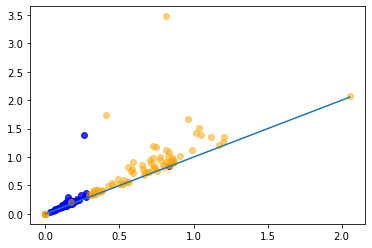

1/1 [==============================] - 7s 7s/step - loss: 4.9337
Epoch 10/10


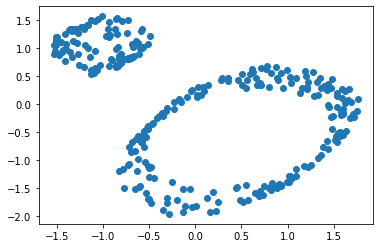

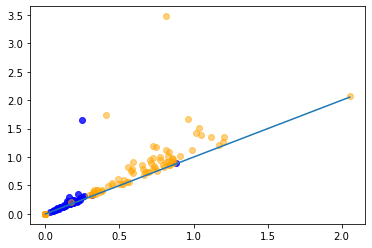

1/1 [==============================] - 7s 7s/step - loss: 4.8243


In [25]:
n_samples = 300

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=10,batch_size=n_samples)

# Swiss Roll with hole

In [127]:
from sklearn.utils import check_random_state

In [128]:
def make_swiss_roll_with_hole(n_samples=100, noise=0.0, random_state=None):
    # https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/datasets/_samples_generator.py#L1401
    generator = check_random_state(random_state)
    t = 1.5 * np.pi * (1 + 2 * generator.rand(1, n_samples))
    x = t * np.cos(t)
    y = 21 * generator.rand(1, n_samples)
    z = t * np.sin(t)

    X = np.concatenate((x, y, z))

    # ranges of three coordinates:
    # np.max(X[2,:]) = 14.136094274051034
    # np.min(X[2,:]) = -11.040707948365629
    # np.max(X[1,:]) = 20.996180119068676
    # np.min(X[1,:]) = 0.004955591716158225
    # np.max(X[0,:]) = 12.60593128332993
    # np.min(X[0,:]) = -9.47727415039662

    # mask = ((X[0, :]>-8) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    # mask = ((X[0, :]>-10) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    mask = ((X[0, :]>-10) & (X[0, :]<-5) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    X[:, mask] = None
    
    X += noise * generator.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)

    # remove the nan values (related to hole):
    hole_point_indices_3D = np.isnan(X)
    hole_point_indices = np.asarray([(hole_point_indices_3D[i, 0] | hole_point_indices_3D[i, 1] | hole_point_indices_3D[i, 2]) for i in range(hole_point_indices_3D.shape[0])])
    t = t[~hole_point_indices]
    X = X[~hole_point_indices]

    return X

In [45]:
swiss = make_swiss_roll_with_hole(n_samples = 10000)

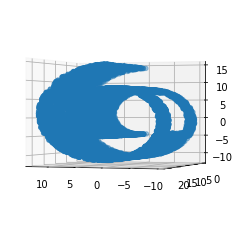

In [50]:
fig = plt.figure(figsize=plt.figaspect(1))
ax=fig.add_subplot(projection='3d')
ax.scatter(swiss[:,0],swiss[:,1],swiss[:,2])
ax.view_init(0,110)

Observation: The persistence diagrams look different for different variations of the swiss role with a hole, even with 0 noise

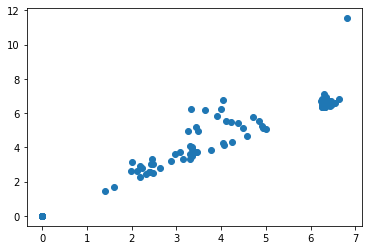

In [23]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = swiss)

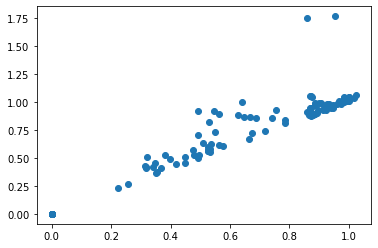

In [40]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = normalize(swiss))

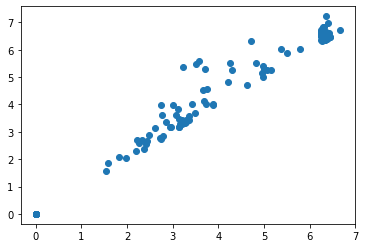

In [42]:
np.random.seed(4)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = swiss)

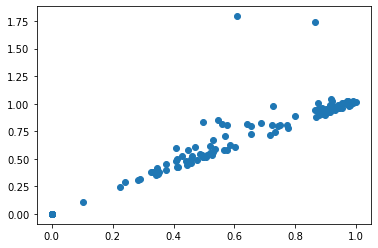

In [43]:
np.random.seed(4)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
PD(X = normalize(swiss))

They look different

# Functions

In [125]:
def PD(X):
    X = np.array(X, dtype = np.float32) 
    modelR = RipsModel(P=X,X=X, mel=12, dim=1, card = 150)
    Xdgm = modelR.call()[0]
    plt.scatter(Xdgm.numpy()[:,0],Xdgm.numpy()[:,1],alpha=0.5)
    return 

In [126]:
def plot(X,dim = 3,deg=45):
    
    if dim==3:
        fig = plt.figure(figsize=plt.figaspect(1))
        ax=fig.add_subplot(projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2])
        ax.view_init(0,deg)
        
    return 

Debug NN
- cylinder
- add layers (depth) not nodes
- scale data
- learning rate


Look at persistence diagram of swiss role without scaling 
Try different scalings on cylinder dataset
- observe what the scale is 